In [3]:
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fsolve, minimize,basinhopping
#import cpfort
import crystal_plasticity_module as cp
import yieldfuncs as yf
import f2py_yldfit as fyf
import odflib
import pandas as pd
import os
from pathlib import Path

Cannot import cpfort module for fortran accelerated Alamel calculations. Python Alamel will be run.


In [4]:
#Define functions to read PCYS files either as outputted dircetly from VPSC or filtered
def read_5d_PCYS(file):
    data = pd.read_csv(file, sep='\s+', skiprows=13, skipfooter=1,engine='python')
    data = data.to_numpy()
    S = data[:,4:] 
    return S

def read_2d_PCYS(file):
    data = np.loadtxt(file, skiprows=1, usecols=(0,1))
    data = np.append(data, np.zeros((len(data),3)),axis=1)
    return data

def read_5d_PCYS_filtered(file):
    S = np.loadtxt(file)
    return S


'INDICES OF THE COMPONENTS DEFINING STRESS SPACE'  
   1 = (S22-S11)/SQRT(2)'  
   2 = (2*S33-S22-S11)/SQRT(6)'  
  3 = S23*SQRT(2)'  
   4 = S13*SQRT(2)'  
   5 = S12*SQRT(2)  

In [5]:
#Define functions to convert b-basis Voigt notation to 3x3 stress tensors: note that this is for the VPSC b-basis
def stress_from_natural_vpsc(S):
    # Define basis matrices
    b1 = 1/np.sqrt(2) * np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]])
    b2 = 1/np.sqrt(6) * np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 2]])
    b3 = 1/np.sqrt(2) * np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]])
    b4 = 1/np.sqrt(2) * np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]])
    b5 = 1/np.sqrt(2) * np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])

    # Stack basis matrices along a new dimension (shape: (3, 3, 5))
    basis_matrices = np.stack([b1, b2, b3, b4, b5], axis=2)
    # Ensure S has shape (7680, 5)
    S = S.T  # Transpose S to get shape (5, 7680)
    
    # Expand S for broadcasting (shape becomes (1, 1, 5, 7680))
    S_expanded = S[np.newaxis, np.newaxis, :, :]
    
    # Perform element-wise multiplication and sum along the basis matrix dimension (axis=2)
    stress_tensors = np.sum(S_expanded * basis_matrices[..., np.newaxis], axis=2)
    
    return stress_tensors

#Do not use
def stresses_from_bbasis(s):
    S1,S2,S3,S4,S5 = s[:,0],s[:,1],s[:,2],s[:,3],s[:,4]
    S11 = S2/np.sqrt(6) - S1/np.sqrt(2)
    S22 = S11 + S1 * np.sqrt(2)
    S33 = -(S11 + S22)
    S12 = S5 / np.sqrt(2)
    S13 = S4 / np.sqrt(2)
    S23 = S3 / np.sqrt(6)
    
    return np.array([[S11,S12,S13],
                     [S12,S22,S23],
                     [S13,S23,S33]])

In [6]:
# Combine the above functions to a single function that loads a PCYS file, transforms it to tensor representation and loads into fortran
def load_stresses(file,filtered=False):
    try:
        s = read_5d_PCYS_filtered(file)
    except:
        s = read_5d_PCYS(file)
    s = stress_from_natural_vpsc(s)
    fyf.py2f_yldfun.py2f_stresses(s)
    #print(f'stresses loaded into fortran with shape: {fyf.py2f_yldfun.s_list.shape}\n first element:{fyf.py2f_yldfun.s_list[:,:,0]}')



In [ ]:
coef = np.ones(16)
a = 8.
coef = np.concatenate((coef,[a]))
NT = 1
sigY = 3.
case = 'YLD2004_18p'

model = 'YLD2004_18p'
yfun = {'func':model, 
        'coef':coef, 
        'exp':a, 
        'Ntransf':NT,
        'y0':sigY}

bounds = [tuple(x) for x in len(coef)*[[None,None]]]
bounds[-1]= [2,14]
bounds = tuple(bounds)

sol = minimize(yf.get_coefa, x0=coef, args=(model, NT, sigY), method='slsqp', constraints=(), jac=None, tol=None, callback=None, options={'maxiter': 10000, 'disp': True})
#sol = basinhopping(yf.get_coefa, x0=coef, niter=50, T=1, stepsize=1, minimizer_kwargs={'method':'SLSQP','args':(model, NT, sigY),'bounds':bounds}, take_step=None, accept_test=None, callback=None, interval=50, disp=True, niter_success=None, seed=None)
yfun['coef'] = sol.x
yfun['coef'] = np.append([1,1],sol.x[:-1])
yfun['exp'] = sol.x[-1]
yfun['info'] = case
yfun['residual'] = sol.fun

print(yfun['residual'],'\n',yfun['coef'],yfun['exp'])

In [5]:
#helper function
def clean_folder(directory):    
    base_directory = directory

    # Loop through all subdirectories and files
    for root, dirs, files in os.walk(base_directory):
        for file in files:
            # Check if the file ends with '.OUT' (case-sensitive)
            if file.endswith('.OUT'):
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Deleted {file_path}")
                except Exception as e:
                    print(f"Failed to delete {file_path}: {e}")

def initialize_bounds(mode):
    coefs = np.ones(16)
    a = 8.
    if mode == 'get_coefa':
        coefs = np.concatenate((coefs,[a]))
        bounds = [tuple(x) for x in len(coefs)*[[None,None]]]
        bounds[-1]= (2,50)
        return tuple(bounds),coefs,a
    else:
        bounds = [tuple(x) for x in len(coefs)*[[None,None]]]
        bounds.append((2,50))
        return tuple(bounds),coefs,a

In [7]:
# Define function to sort PCYS files in folders from random texture up to 200% strain - assumes filenames are PCYS_XXX where XXX is 0,1,2... with PCYSrand being first
def custom_sort_key(file_path):
    if file_path.name == 'PCYSrand.OUTF':
        return -1  
    return int(file_path.stem.split('_')[-1])

def subfolder_sort_key(folder):
        return int(folder.name[6:])

def get_sorted_file_lists(base_folder):
  
    base_folder = Path(base_folder)
    sorted_file_lists = []

    # Iterate through each subfolder
    for subfolder in sorted(base_folder.iterdir(),key=subfolder_sort_key):
        if subfolder.is_dir():
            # Get all files in the subfolder
            files = list(subfolder.glob("*"))
            # Sort files using the custom sort key
            sorted_files = sorted(files, key=custom_sort_key)
            sorted_file_lists.append(sorted_files)

    return sorted_file_lists

sorted_files = get_sorted_file_lists('FilteredPCYS')
np.array(sorted_files).shape

(10, 21)

In [ ]:
# Fitting function: Takes in list of WindowsPath objects to each (sorted) PCYS file and calculates the complete set of coefficients, exponents and residuals
NT = 1
sigY = 3.
case = 'YLD2004_18p'

def coefficient_calculator_full(full_files,model='YLD2004_18p', mode='get_coefa', minimizer='basinhopping',bounded=True):
    if isinstance(full_files[0],Path):
        full_files = [full_files]
    
    bounds,coefs,a = initialize_bounds(mode)

    all_coefs = np.zeros((18,21,10))
    all_exps = np.zeros((21,10))
    all_res = np.zeros((21,10))

    forward_multiplier = 2.5  # scale the forward bound up to 250% of the last change
    backward_multiplier = .3 # limit the backward bound to 50% of the last change for stability
    min_tolerance = 0.075 
    
    for L,files in enumerate(full_files):
        #reset bounds for the next Velocity gradient file
        lower_bounds = []
        upper_bounds = []
        tracked_coef = []
        
        bounds = [tuple(x) for x in len(coefs)*[[None,None]]]
        bounds[-1]= (2,50)
        
        for i, file in enumerate(files):
            load_stresses(file)
            
            yfun = {'func':model, 
                    'coef':coefs,
                    'info':model, 
                    'exp':a, 
                    'Ntransf':NT,
                    'y0':sigY}
            
            if mode =='get_coefa':
                if minimizer =='minimize':
                    sol = minimize(yf.get_coefa, x0=coefs, args=(model, NT, sigY), method='slsqp', constraints=(),bounds=bounds, jac=None, tol=10**-10, callback=None, options={'maxiter': 10000, 'disp': True}) 
                else:
                    sol = basinhopping(yf.get_coefa, x0=coefs, niter=50, T=1, stepsize=0.5, minimizer_kwargs={'method':'slsqp','args':(model, NT, sigY),'bounds':bounds,'tol':10**-10}, take_step=None, accept_test=None, callback=None, interval=50, disp=True, niter_success=None, seed=None)
                

                yfun['coef'] = np.append([1,1],sol.x[:-1])
                yfun['exp'] = sol.x[-1]
                
                
            if mode =='get_coef':
                #get coef
                if minimizer == 'minimize':
                    sol = minimize(yf.get_coef, x0=coefs, args=(model,a, NT, sigY), method='slsqp', constraints=(),bounds=bounds, jac=None, tol=10**-10, callback=None, options={'maxiter': 10000, 'disp': True}) 
                else:
                    sol = basinhopping(yf.get_coef, x0=coefs, niter=50, T=1, stepsize=0.5, minimizer_kwargs={'method':'slsqp','args':(model,a, NT, sigY),'bounds':bounds,'tol':10**-10}, take_step=None, accept_test=None, callback=None, interval=50, disp=True, niter_success=None, seed=None)

                yfun['exp'] = a
                yfun['coef'] = np.append([1,1],sol.x)
            
            # Loop to update bounds for each coefficient
            tracked_coef.append(sol.x[0])
            
            #Bounding procedure: Calculate bounds based on the "direction" of the coefficient to ensure smooth changes in coefficients
            if bounded == True:
                bounds = [(None, None)] * len(coefs) #Reset bounds for each new iteration to prevent new L to be bounded by previous run
                for j in range(len(coefs)):
                    prev_val = coefs[j]
                    current_val = sol.x[j]
                    
                    # Calculate the change from previous coefficient to current coefficient
                    change = current_val - prev_val
                    
                    if change > 0:
                    # Moving up: Allow a wider range forward, narrower backward
                        lower_bound = current_val  - max(abs(change) * backward_multiplier, min_tolerance) #apply minimum bound in case of small change
                        upper_bound = current_val  + max(abs(change) * forward_multiplier, min_tolerance)
                    else:
                    # Moving down: Allow a wider range downward, narrower upward
                        lower_bound = current_val - max(abs(change) * forward_multiplier, min_tolerance)
                        upper_bound = current_val + max(abs(change) * backward_multiplier, min_tolerance)
                    
                    # Update bounds for this coefficient
                    bounds[j] = (lower_bound, upper_bound)
                    
                bounds[-1] = (2,50)    
                bounds = tuple(bounds)
                lower_bounds.append(bounds[0][0])
                upper_bounds.append(bounds[0][1])
   
            yfun['residual'] = sol.fun
            if mode == 'get_coefa':
                coefs = np.concatenate((yfun['coef'][2:],[yfun['exp']]))
            else:
                coefs = yfun['coef'][2:]
            
            all_coefs[:,i,L] = yfun['coef']
            all_exps[i,L] = yfun['exp']
            all_res[i,L] = yfun['residual']
        
        plt.figure(figsize=(10, 6))
        plt.plot(range(21),all_exps[:,L],'-r')
        plt.plot(range(21),all_res[:,L],'-b')
        plt.show()
        
        if bounded:
            lower_bounds = [None] + lower_bounds[:-1]
            upper_bounds = [None] + upper_bounds[:-1]

            plt.figure(figsize=(10, 6))
            plt.plot(range(len(files)), lower_bounds, label='Lower Bound', marker='o')
            plt.plot(range(len(files)), upper_bounds, label='Upper Bound', marker='o')
            plt.plot(range(len(files)), tracked_coef, label='coef', marker='x')
            plt.xlabel('Iteration (i)')
            plt.ylabel('Bounds for Coefficient 0')
            plt.title('Bounds Evolution for Coefficient 0')
            plt.legend()
            plt.grid(True)
            plt.show()
    
    return all_coefs, all_exps, all_res


sorted_files = get_sorted_file_lists('FilteredPCYS')
calc_coefs, calc_exps, calc_res = coefficient_calculator_full(sorted_files[9],minimizer='minimize',bounded = True)

In [ ]:
coef = np.ones(16)
a = 8.
coef = np.concatenate((coef,[a]))
NT = 1
sigY = 3.
case = 'YLD2004_18p'
plots = [('11','22','12',[0,0.5,1])]


def coefficient_calculator(files,model='YLD2004_18p', mode='get_coefa', minimizer=minimize,bounded=True):
    coefs = np.ones(16)
    a = 8.
    if mode == 'get_coefa':
        coefs = np.concatenate((coefs,[a]))
        bounds = [tuple(x) for x in len(coefs)*[[None,None]]]
        bounds[-1]= (2,50)
    else:
        bounds = [tuple(x) for x in len(coefs)*[[None,None]]]
        bounds.append((2,50))
    all_gs = np.zeros((21,3,3,400*len(plots[0][3])))
    all_coefs = np.zeros((18,21))
    all_exps = np.zeros((21))
    all_res = np.zeros((21))

    forward_multiplier = 3  # scale the forward bound up to 200% of the last change
    backward_multiplier = 1.3 # limit the backward bound to 30% of the last change for stability
    min_tolerance = 0.03 
    
    bounds = tuple(bounds)

    lower_bounds = []
    upper_bounds = []
    tracked_coef =[]

    for i, file in enumerate(files):
        load_stresses(file)
        
        yfun = {'func':model, 
                'coef':coef,
                'info':model, 
                'exp':a, 
                'Ntransf':NT,
                'y0':sigY}
        
        if mode =='get_coefa':
            if minimizer =='minimize':
                sol = minimize(yf.get_coefa, x0=coefs, args=(model, NT, sigY), method='slsqp', constraints=(),bounds=bounds, jac=None, tol=10**-10, callback=None, options={'maxiter': 10000, 'disp': True}) 
            else:
                sol = basinhopping(yf.get_coefa, x0=coefs, niter=50, T=1, stepsize=0.5, minimizer_kwargs={'method':'slsqp','args':(model, NT, sigY),'bounds':bounds,'tol':10**-10}, take_step=None, accept_test=None, callback=None, interval=50, disp=True, niter_success=None, seed=None)
            

            yfun['coef'] = np.append([1,1],sol.x[:-1])
            yfun['exp'] = sol.x[-1]
            
            
        if mode =='get_coef':
            #get coef
            if minimizer == 'minimize':
                sol = minimize(yf.get_coef, x0=coefs, args=(model,a, NT, sigY), method='slsqp', constraints=(),bounds=bounds, jac=None, tol=10**-10, callback=None, options={'maxiter': 10000, 'disp': True}) 
            else:
                sol = basinhopping(yf.get_coef, x0=coefs, niter=50, T=1, stepsize=0.5, minimizer_kwargs={'method':'slsqp','args':(model,a, NT, sigY),'bounds':bounds,'tol':10**-10}, take_step=None, accept_test=None, callback=None, interval=50, disp=True, niter_success=None, seed=None)

            yfun['exp'] = a
            yfun['coef'] = np.append([1,1],sol.x)
        
        # Loop to update bounds for each coefficient
        tracked_coef.append(sol.x[0])
        if bounded == True:
            bounds = [(None, None)] * len(coefs)
            for j in range(len(coefs)):
                prev_val = coefs[j]
                new_val = sol.x[j]
                
                # Calculate the recent change and apply a tolerance
                change = new_val - prev_val
                
                if change > 0:
                # Moving up: Allow a wider range forward, narrower backward
                    lower_bound = new_val - max(abs(change) * backward_multiplier, min_tolerance)
                    upper_bound = new_val + max(abs(change) * forward_multiplier, min_tolerance)
                else:
                # Moving down: Allow a wider range downward, narrower upward
                    lower_bound = new_val - max(abs(change) * forward_multiplier, min_tolerance)
                    upper_bound = new_val + max(abs(change) * backward_multiplier, min_tolerance)
                
                # Update bounds for this coefficient
                bounds[j] = (lower_bound, upper_bound)
                
                
            bounds = tuple(bounds)
            lower_bounds.append(bounds[0][0])
            upper_bounds.append(bounds[0][1])
                  
        yfun['residual'] = sol.fun
        if mode == 'get_coefa':
            coefs = np.concatenate((yfun['coef'][2:],[yfun['exp']]))
        else:
            coefs = yfun['coef'][2:]
        
        #gs = yf.genStresses(400,yfun,plot_axes=plots[0])
        #all_gs[i] = gs
        all_coefs[:,i] = yfun['coef']
        all_exps[i] = yfun['exp']
        all_res[i] = yfun['residual']

    if bounded:
        lower_bounds = [None] + lower_bounds[:-1]
        upper_bounds = [None] + upper_bounds[:-1]

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(files)), lower_bounds, label='Lower Bound', marker='o')
        plt.plot(range(len(files)), upper_bounds, label='Upper Bound', marker='o')
        plt.plot(range(len(files)), tracked_coef, label='coef', marker='x')
        plt.xlabel('Iteration (i)')
        plt.ylabel('Bounds for Coefficient 0')
        plt.title('Bounds Evolution for Coefficient 0')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return all_gs,all_coefs, all_exps,all_res

file_paths = sorted_files
all_gs,all_coefs,all_exps, all_res=coefficient_calculator(file_paths,mode='get_coefa',minimizer = 'basinhopping',bounded=False)


In [ ]:
coef = np.ones(16)
a = 8.
coef = np.concatenate((coef,[a]))
NT = 1
sigY = 3.
case = 'YLD2004_18p'
plots = [('11','22','12',[0,0.5,1])]

folder_path = Path('FilteredPCYS\PCYS_L1')  # Replace with your folder path
file_paths = list(folder_path.glob('*'))
file_paths = sorted(file_paths,key=lambda x: int(x.stem.split('_')[-1]))

def coefficient_calculator(files,model='YLD2004_18p', mode='get_coefa', minimizer=minimize):
    coefs = np.ones(16)
    a = 8.
    if mode == 'get_coefa':
        coefs = np.concatenate((coefs,[a]))

    all_coefs = np.zeros((18,20))
    all_exps = np.zeros((20))
    all_res = np.zeros((20))

    theta = np.deg2rad(2.5)

    bounds = [tuple(x) for x in len(coefs)*[[None,None]]]
    bounds[-1]= (2,50)
    bounds = tuple(bounds)

    lower_bounds = []
    upper_bounds = []
    tracked_coef =[]
    
    for i, file in enumerate(files):
        load_stresses(file)
        
        yfun = {'func':model, 
                'coef':coef,
                'info':model, 
                'exp':a, 
                'Ntransf':NT,
                'y0':sigY}
        
        if mode =='get_coefa':
            if minimizer =='minimize':
                sol = minimize(yf.get_coefa, x0=coefs, args=(model, NT, sigY), method='slsqp', constraints=(),bounds=bounds, jac=None, tol=10**-10, callback=None, options={'maxiter': 10000, 'disp': True}) 
            else:
                sol = basinhopping(yf.get_coefa, x0=coefs, niter=50, T=1, stepsize=0.2, minimizer_kwargs={'method':'slsqp','args':(model, NT, sigY),'bounds':bounds,'tol':10**-6}, take_step=None, accept_test=None, callback=None, interval=50, disp=True, niter_success=None, seed=None)
            

            yfun['coef'] = np.append([1,1],sol.x[:-1])
            yfun['exp'] = sol.x[-1]
            
            
        elif mode =='get_coef':
            #get coef
            if minimizer == 'minimize':
                sol = minimize(yf.get_coef, x0=coefs, args=(model,a, NT, sigY), method='slsqp', constraints=(),bounds=bounds, jac=None, tol=10**-10, callback=None, options={'maxiter': 10000, 'disp': True}) 
            else:
                sol = basinhopping(yf.get_coef, x0=coefs, niter=50, T=1, stepsize=0.2, minimizer_kwargs={'method':'slsqp','args':(model,a, NT, sigY),'bounds':bounds,'tol':10**-6}, take_step=None, accept_test=None, callback=None, interval=50, disp=True, niter_success=None, seed=None)

            yfun['exp'] = a
            yfun['coef'] = np.append([1,1],sol.x)
        
        tracked_coef.append(sol.x[0])
        # Loop to update bounds for each coefficient
        bounds = [(None, None)] * len(coefs[:-1])
        bounds.append([2,50])
        for j in range(len(coefs[:-1])):
            prev_val = coefs[j]
            new_val = sol.x[j]
            change = (new_val - prev_val) + new_val
            
          #  y = np.array([(np.sin(theta)-change**2*np.cos(theta))/(-change*np.sin(theta)-np.cos(theta)),(np.sin(theta)+change*np.cos(theta))/(-change*np.sin(theta)+np.cos(theta))])
            y = np.array([(np.sin(theta)+change**2*np.sin(theta))/(-change*np.sin(theta)-np.cos(theta)),(np.sin(theta)+change**2*np.sin(theta))/(-change*np.sin(theta)+np.cos(theta))])
            
            
            lower_bound =  change + np.min(y)
            upper_bound =  change + np.max(y)
            # Calculate the recent change and apply a tolerance
            

            bounds[j] = (lower_bound, upper_bound)
        
        lower_bounds.append(bounds[0][0])
        upper_bounds.append(bounds[0][1])    
        # Convert bounds to tuple format if needed
        bounds = tuple(bounds)
        
        yfun['residual'] = sol.fun
        coefs = np.concatenate((yfun['coef'][2:],[yfun['exp']]))
        gs = yf.genStresses(400,yfun,plot_axes=plots[0])
        
        all_gs[i] = gs
        all_coefs[:,i] = yfun['coef']
        all_exps[i] = yfun['exp']
        all_res[i] = yfun['residual']
        
    lower_bounds = [None] + lower_bounds[:-1]
    upper_bounds = [None] + upper_bounds[:-1]

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(files)), lower_bounds, label='Lower Bound', marker='o')
    plt.plot(range(len(files)), upper_bounds, label='Upper Bound', marker='o')
    plt.plot(range(len(files)), tracked_coef, label='coef', marker='x')
    plt.xlabel('Iteration (i)')
    plt.ylabel('Bounds for Coefficient 0')
    plt.title('Bounds Evolution for Coefficient 0')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    return all_gs,all_coefs, all_exps,all_res

all_gs,all_coefs,all_exps, all_res=coefficient_calculator(file_paths,mode='get_coefa',minimizer = 'minimize')


In [29]:
#Save coefficients, stresses, exponents and residual
save_directory = 'PCYS_COEFS\Full'
filename = 'complete_coefs_bounded(.5,2.5)(L02.5,3)(L92.5,3)'

os.makedirs(save_directory, exist_ok=True)

file_path = os.path.join(save_directory, f'{filename}.npz')

if not os.path.exists(f'{file_path}'):
    np.savez(file_path,all_coefs=all_coefs,all_exps=all_exps, all_res=all_res)
else:
    print('Check if you are overwriting your files')

Check if you are overwriting your files


In [ ]:
# Load back coefficients, stresses, exponents and residuals
filename = r'PCYS_COEFS\L1\basinhopping_L1_unbounded_50iter.npz'
with np.load(f'{filename}') as data:
    all_gs = data['all_gs']
    all_coefs = data['all_coefs']
    all_exps = data['all_exps']
    all_res = data['all_res']

In [17]:
#Load complete set of coefficients, exponents and residuals for all Ls and all strain increments WITH BOUNDS
NT = 1
sigY = 3.
case = 'YLD2004_18p'
#all_coefs shape (18,21,10)
#all_exps shape (21,10)
#all_res shape (21,10)

filename = r'PCYS_COEFS\Full\complete_coefs_bounded(.5,2.5)(L02.5,3)(L92.5,3).npz'
with np.load(f'{filename}') as data:
    all_coefs = data['all_coefs']
    all_exps = data['all_exps']
    all_res = data['all_res']

for i in range(10):
    all_coefs[:,0,i] = all_coefs[:,0,1]
    all_exps[0,i] = all_exps[0,1]

In [31]:
import numpy as np
import csv

# Load the data
filename = r'PCYS_COEFS\Full\complete_coefs_bounded(.5,2.5)(L02.5,3)(L92.5,3).npz'
with np.load(f'{filename}') as data:
    all_coefs = data['all_coefs']  # Shape (18, 21, 10)
    all_exps = data['all_exps']    # Shape (21, 10)
    all_res = data['all_res']      # Shape (21, 10)

# Define ranges for phi and epsilon
phi_values = np.linspace(0, np.pi/4, all_coefs.shape[2])  # Adjust angle range as needed
epsilon_values = np.linspace(0, 2, all_coefs.shape[1])  # Adjust strain range as needed

# Prepare the output data
output_data = []

# Iterate through all combinations of epsilon and phi
for j, epsilon in enumerate(epsilon_values):  # Loop over strains (dimension 21)
    for k, phi in enumerate(phi_values):      # Loop over angles (dimension 10)
        row = {
            "phi": phi,
            "epsilon": epsilon,
            "coefs": all_coefs[2:, j, k].tolist(),  # Coefficients (dimension 18)
            "exps": all_exps[j, k],               # Exponent                          
        }
        output_data.append(row)

# Write the data to a CSV file
csv_filename = "output_parameters29.11.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    #writer.writerow(["phi", "epsilon"] + [f"coef_{i+1}" for i in range(all_coefs.shape[0])] + ["exp"])
    #writer.writerow(["phi", "epsilon"] + [f"coef_{i+1}" for i in range(all_coefs.shape[0])])
    writer.writerow(["phi", "epsilon"] + [f"coef_{i+3}" for i in range(all_coefs.shape[0]-2)])
    
    # Write each row of data
    for row in output_data:
       # writer.writerow([row["phi"], row["epsilon"]] + row["coefs"] + [row["exps"]])
        writer.writerow([row["phi"], row["epsilon"]] + row["coefs"])

print(f"Data successfully written to {csv_filename}")


Data successfully written to output_parameters29.11.csv


In [21]:
#Load complete set of residuals for all Ls and all strain increments WITHOUT BOUNDS
filename = r'PCYS_COEFS\Full\complete_coefs_2.npz'
with np.load(f'{filename}') as data:
    unbounded_res = data['all_res']

In [20]:
#Load SINGLE set with many basinhopping iterations (1000) of residuals for all Ls and all strain increments WITHOUT BOUNDS
filename = r'PCYS_COEFS\L1\basinhopping_L1_1000iter.npz'
with np.load(f'{filename}') as data:
    manyiter_res = data['all_res']

In [54]:
#Load complete set of coefficients and exponents from ANN
model = 'YLD2004_18p'
file_paths = sorted_files
filename = r'PCYS_COEFS\Full\ML_coefs_0279.npz'
with np.load(f'{filename}') as data:
    ML_coefs = data['ML_coefs']
    # ML_exps = data['ML_exps']

ML_res = np.zeros((210,10))

coef_mod = np.zeros((200, 210, 10))  # Assuming 200 entries for the first dimension
coef_mod[:18, :, :] = ML_coefs
for j in range(10):  # Loop over cases
    for i in range(21):  # Loop over strain increments
        load_stresses(file_paths[j][i])  # Ensure file_paths[j][i] loads correctly
        
        # Use the coefficients for the 0th strain increment (index 0) repeated for all increments
        res = fyf.py2f_yldfun.get_residual(coef_mod[:, 10*i, j], model, all_exps[i,j], NT, sigY)
        ML_res[10*i, j] = res  # Store the residual


In [19]:
#Copy the coefficients and exponents for random texture fitting calculate residuals for all strain increments
file_paths = sorted_files
model ='YLD2004_18p'
a = all_exps[0]
print(a)
# Tile the 0th strain increment coefficients across all increments for each L
randtex_coefs = np.tile(all_coefs[:, 0, :], (21, 1, 1))  # Shape (21, 18, 10)
randtex_coefs = np.transpose(randtex_coefs, (1, 0, 2))  # Shape (18, 21, 10)

# Initialize the coefficient modification array with the correct shape
coef_mod = np.zeros((200, 21, 10))  # Assuming 200 entries for the first dimension
coef_mod[:18, :, :] = randtex_coefs  # Assign the tiled coefficients
# Prepare the array for unchanged residuals
unchanged_res = np.zeros((21, 10))

# Loop through strain increments and cases
for j in range(10):  # Loop over cases
    for i in range(21):  # Loop over strain increments
        load_stresses(file_paths[j][i])  # Ensure file_paths[j][i] loads correctly
        
        # Use the coefficients for the 0th strain increment (index 0) repeated for all increments
        res = fyf.py2f_yldfun.get_residual(coef_mod[:, i, j], model, a[j], NT, sigY)
        unchanged_res[i, j] = res  # Store the residual

[8.25247757 8.25247757 8.25247757 8.25247757 8.25247757 8.25247757
 8.25247757 8.25247757 8.25247757 8.25247757]


In [36]:
#Adjust residuals to be average error per point
points = np.zeros((21,10))
for i,L_files in enumerate(sorted_files):
    for j, file in enumerate(L_files):
        s = read_5d_PCYS_filtered(file)
        points[j,i] = len(s)

#points[j,i] = number of probes used in the ith L for the jth strain increment

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

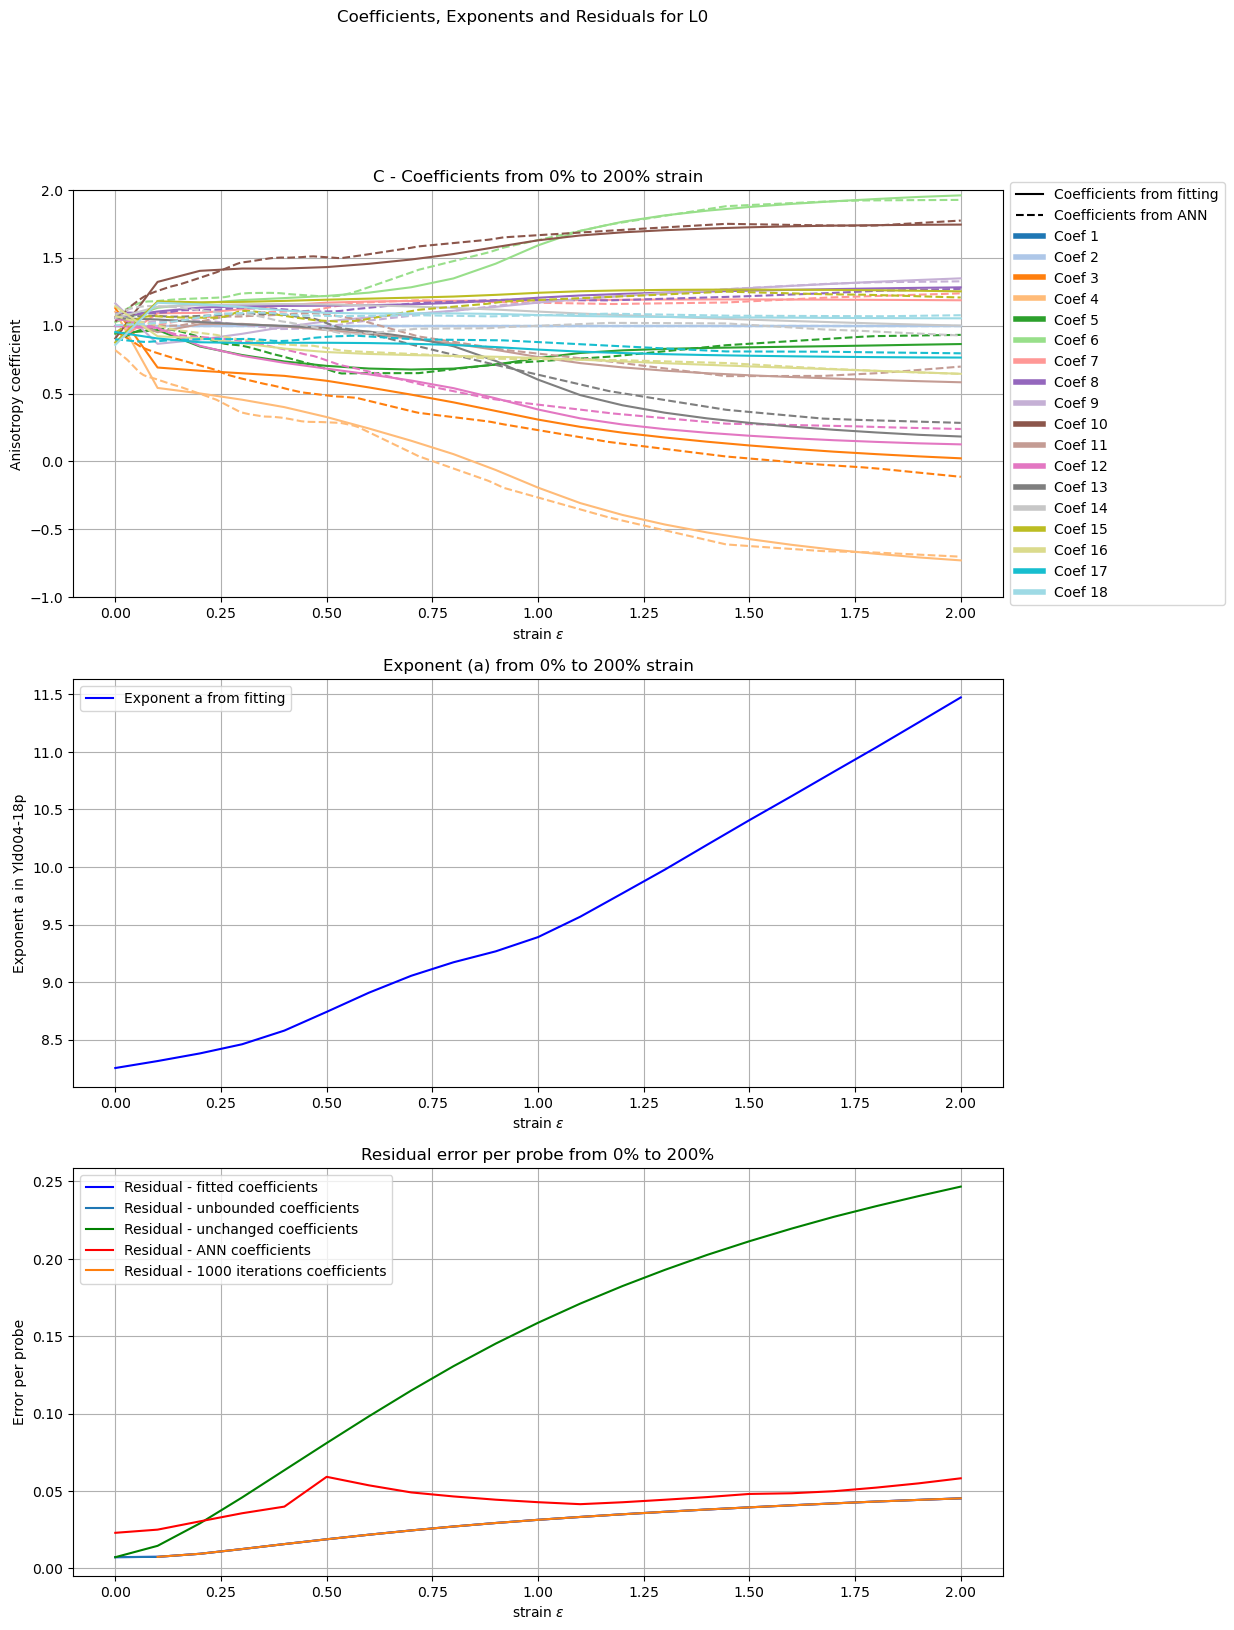

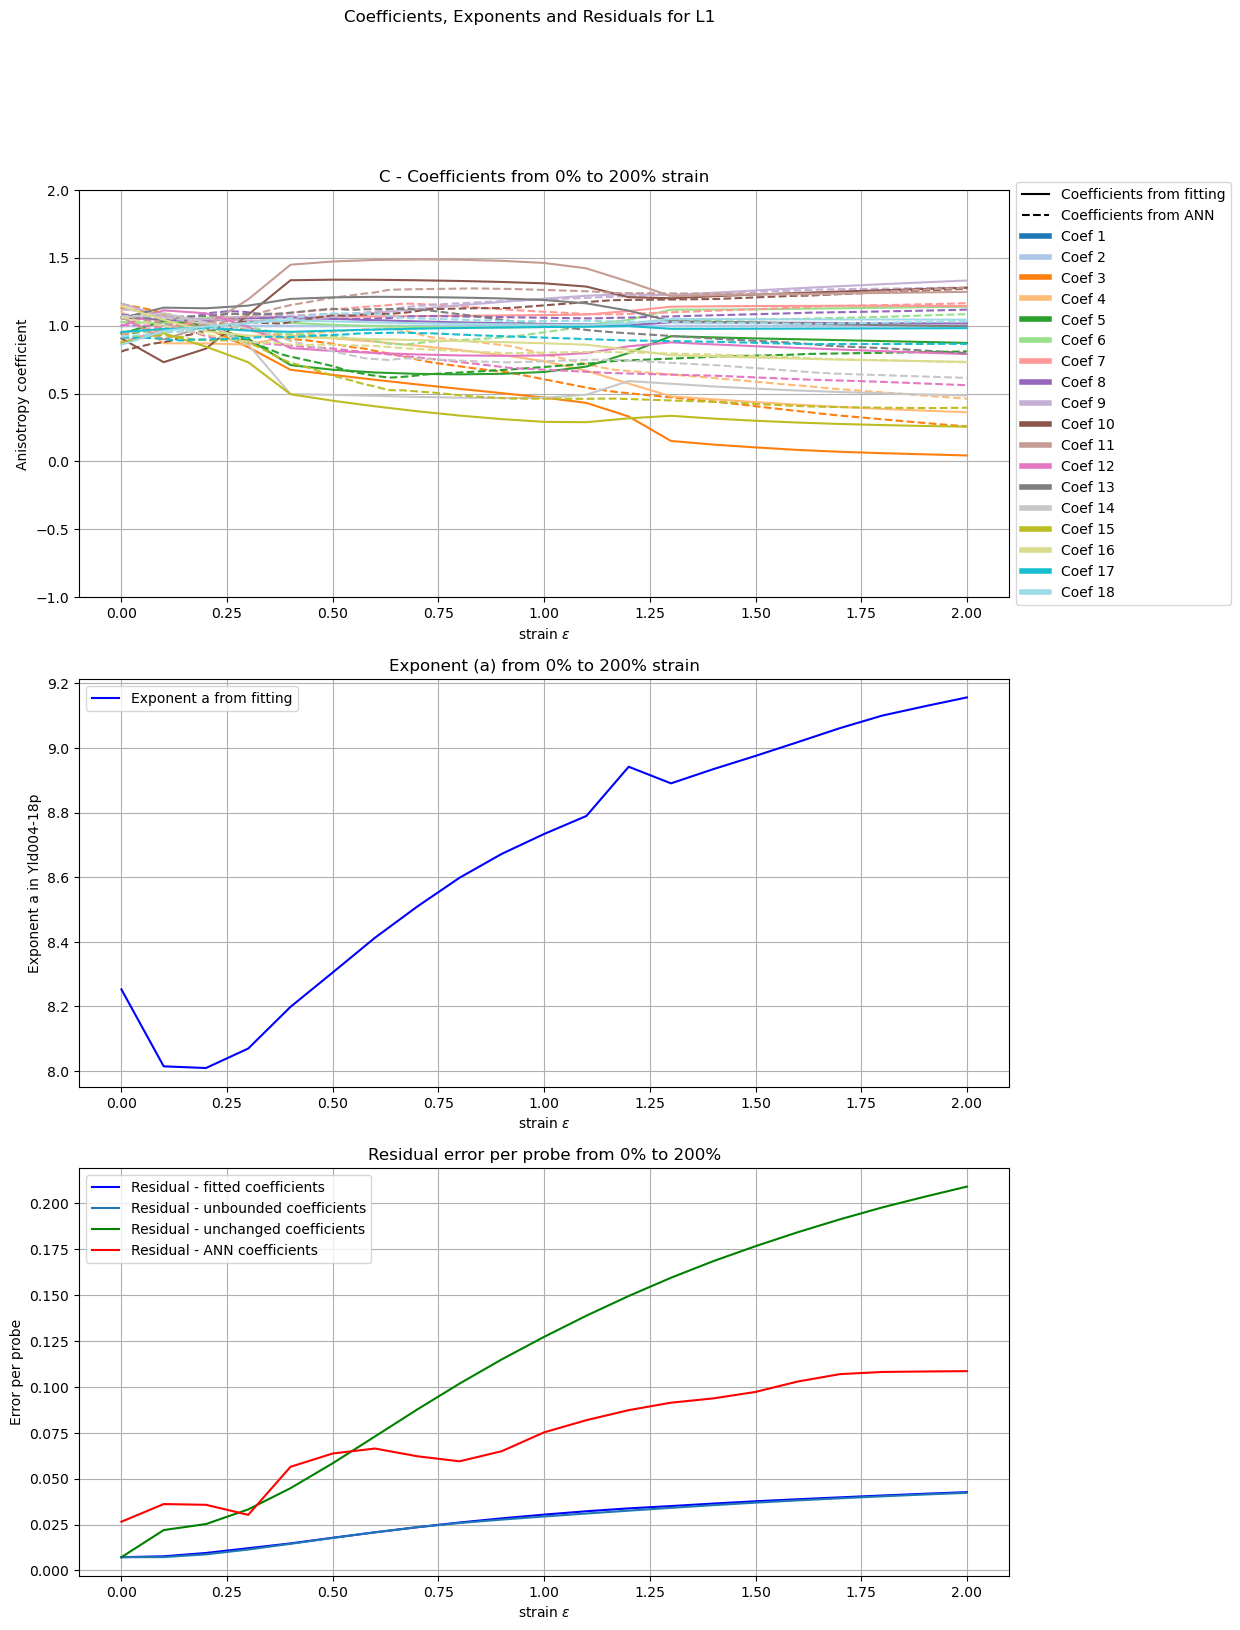

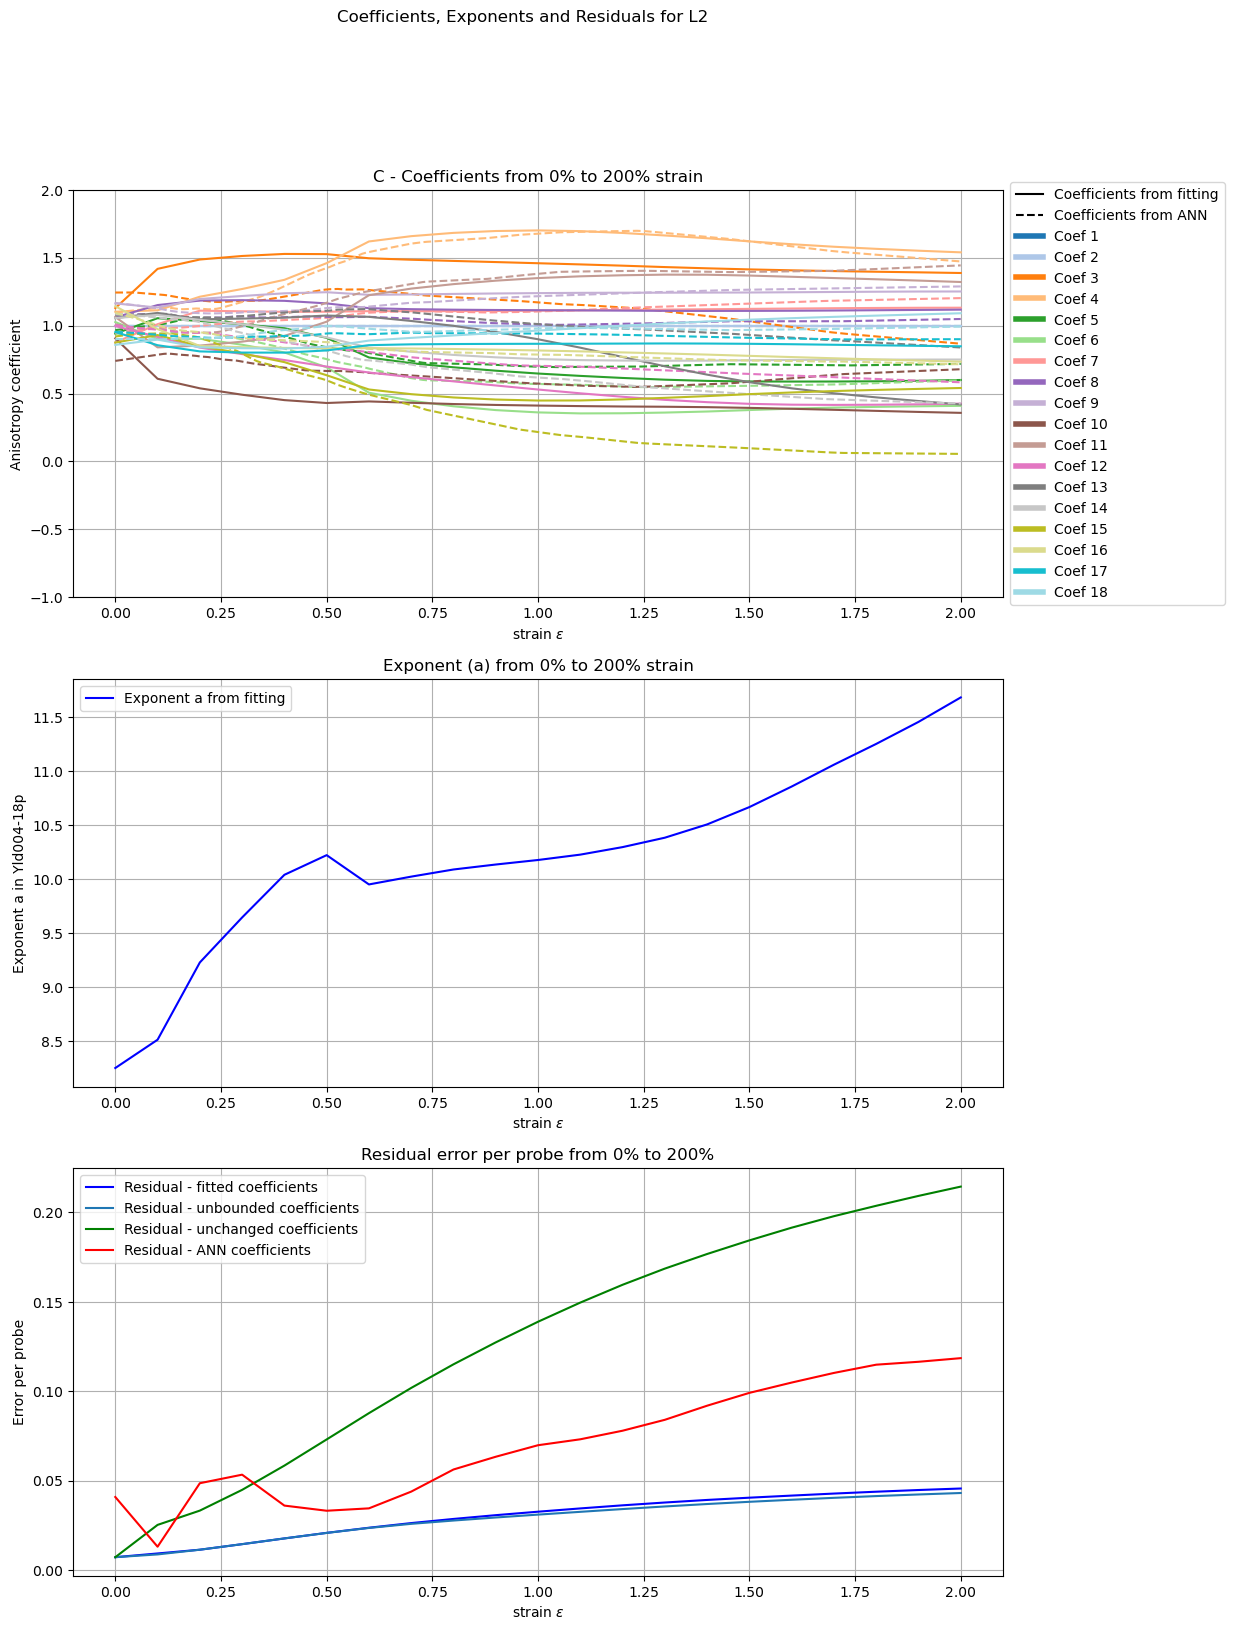

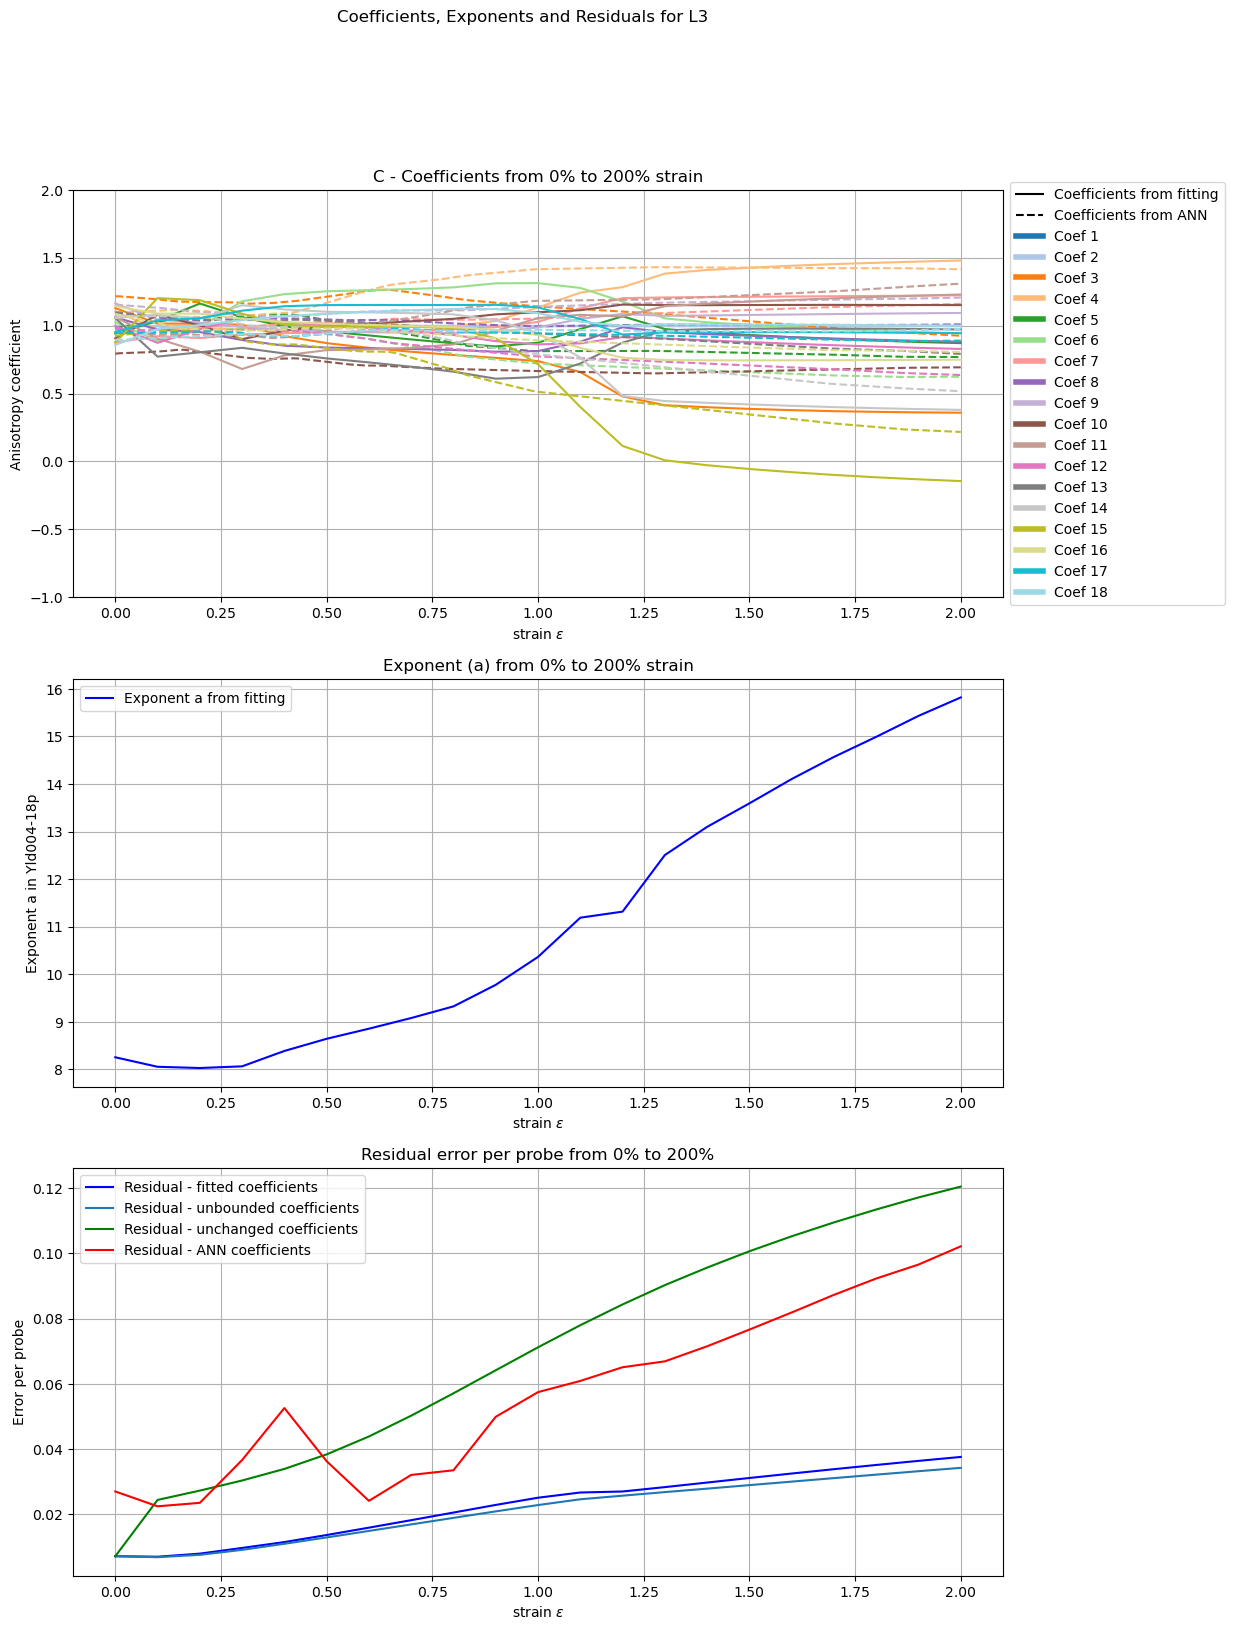

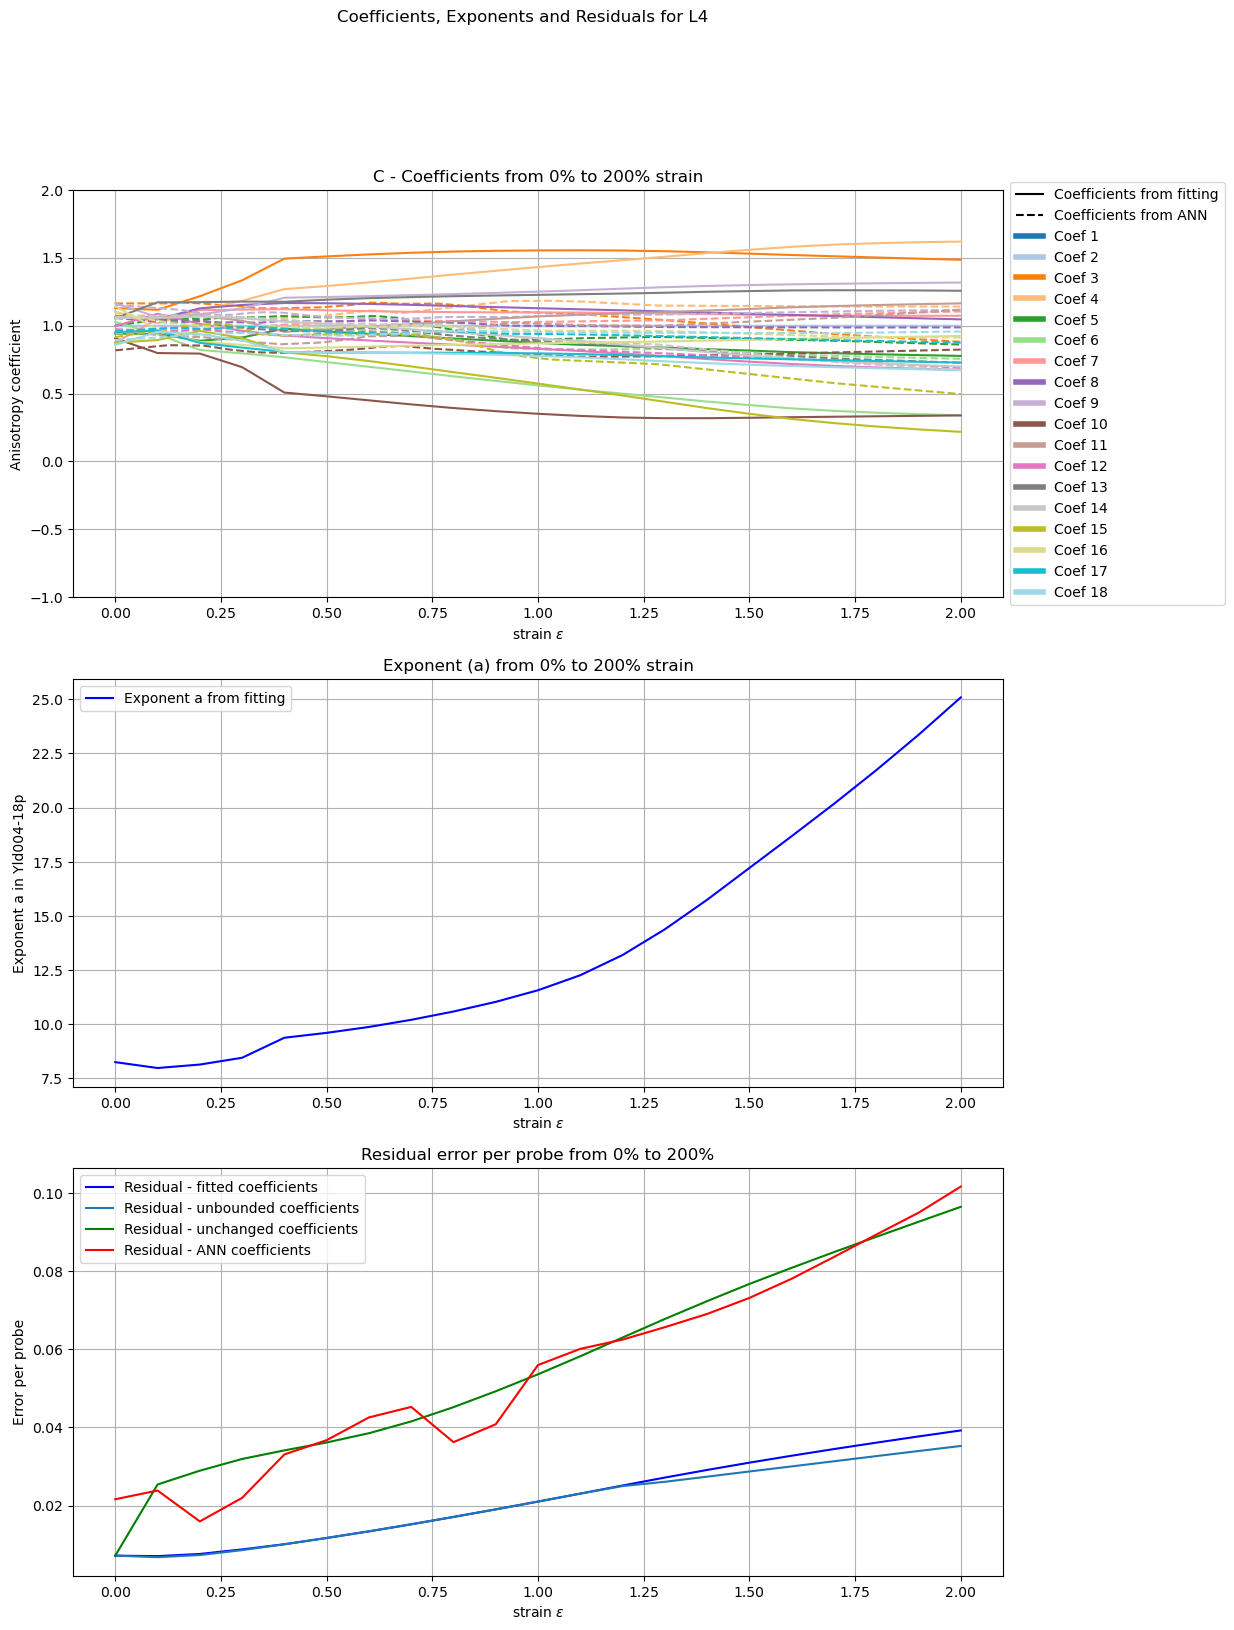

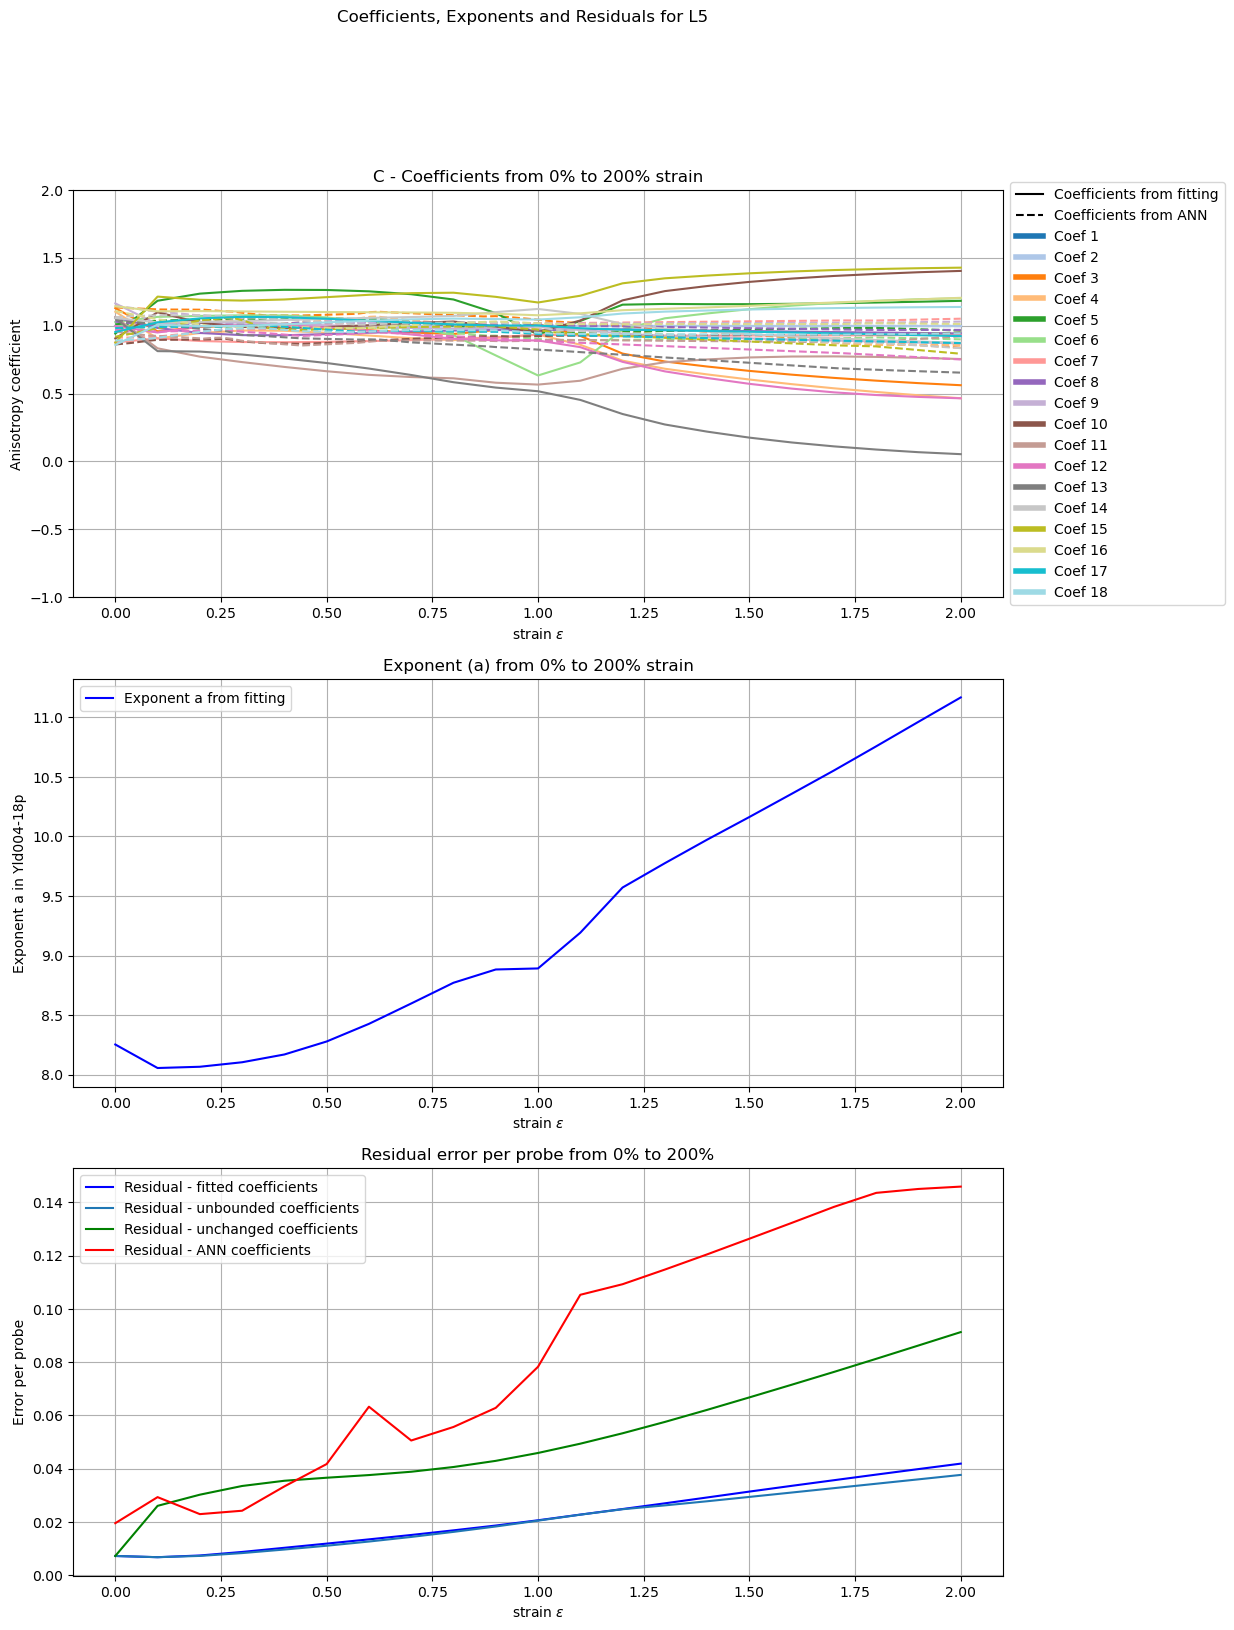

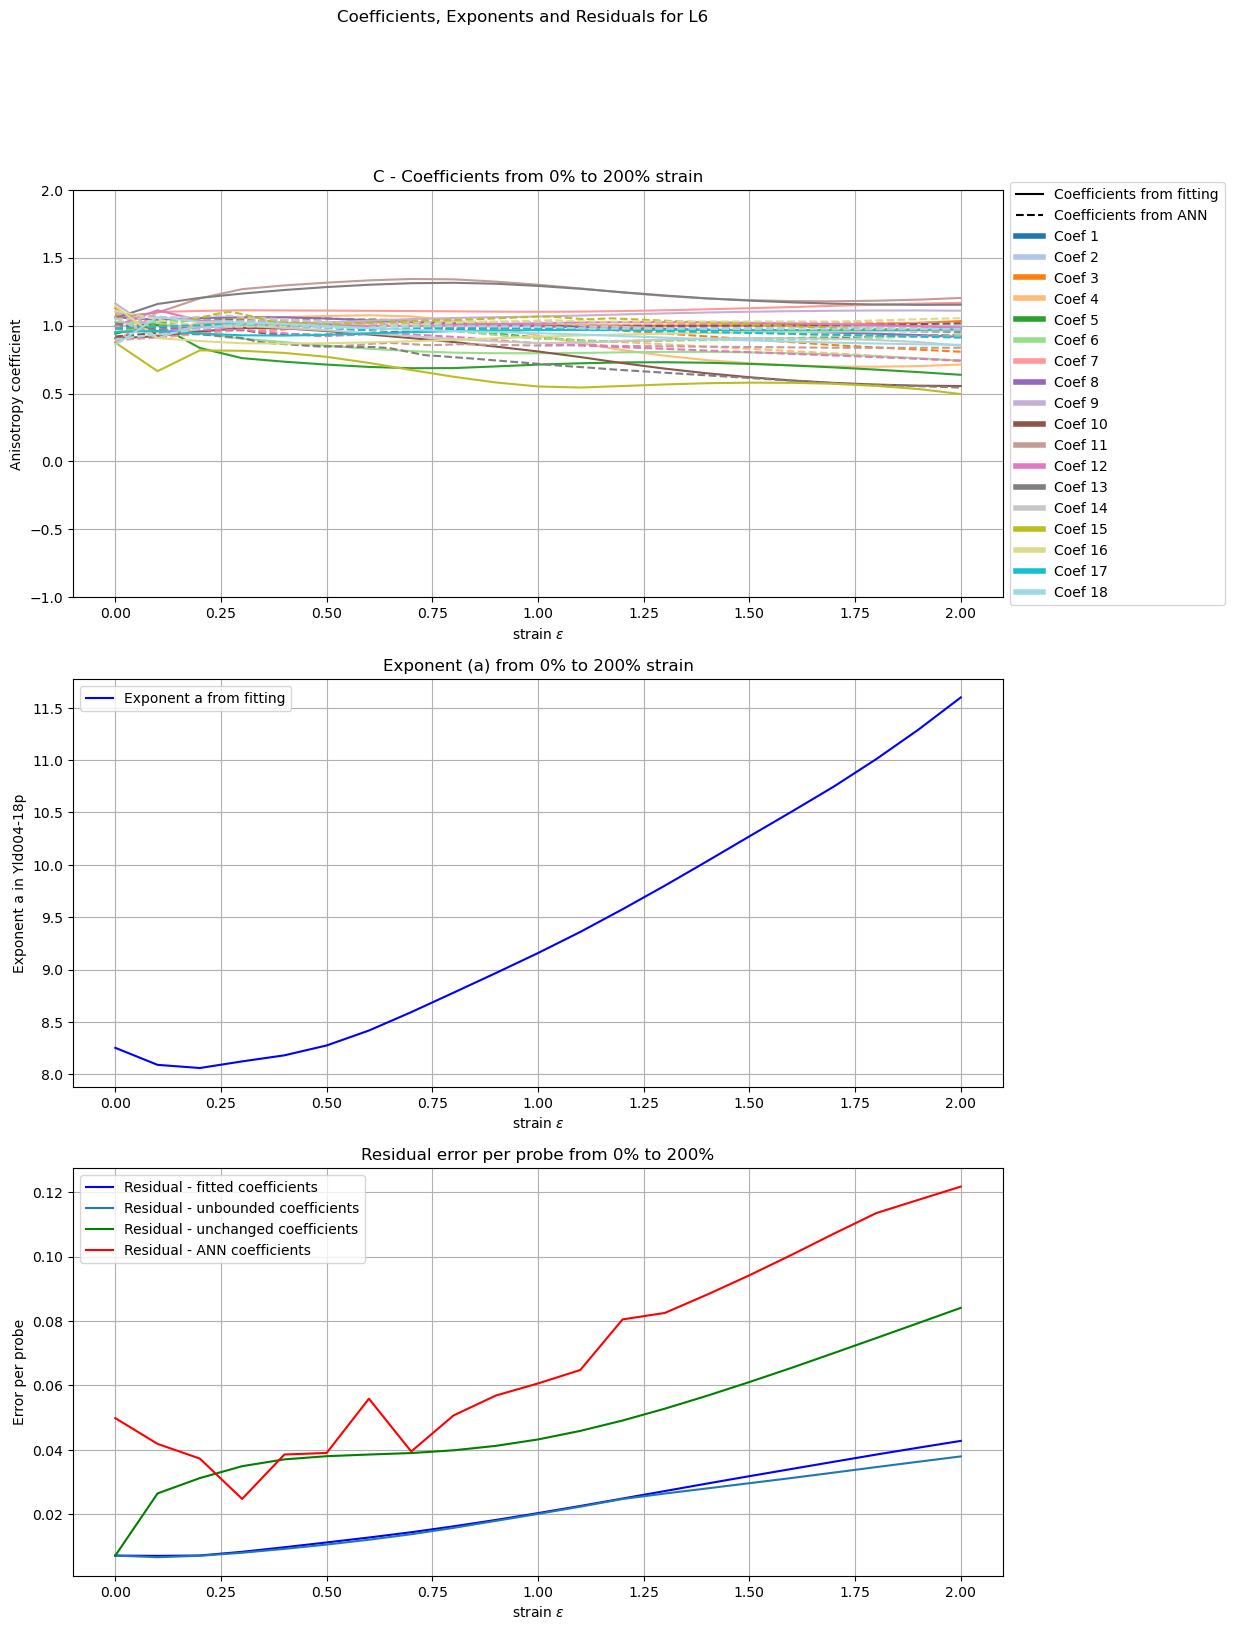

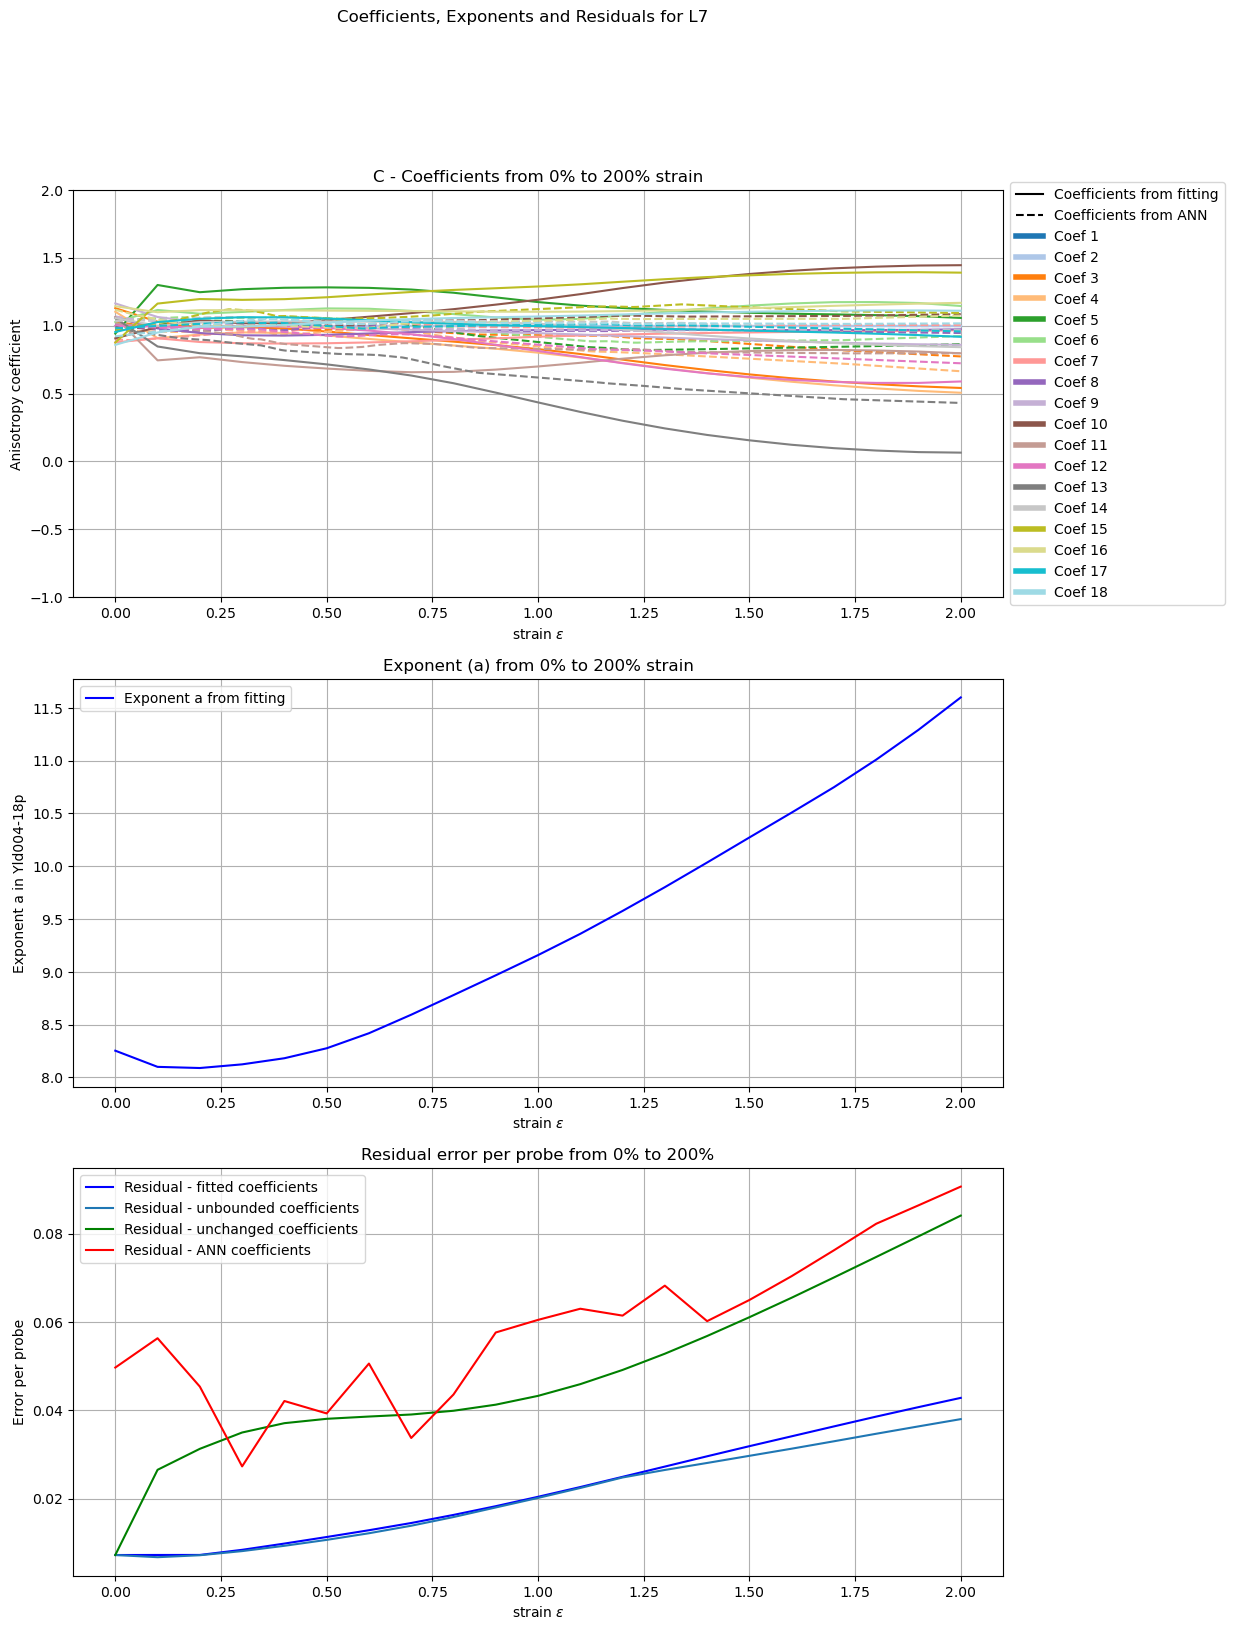

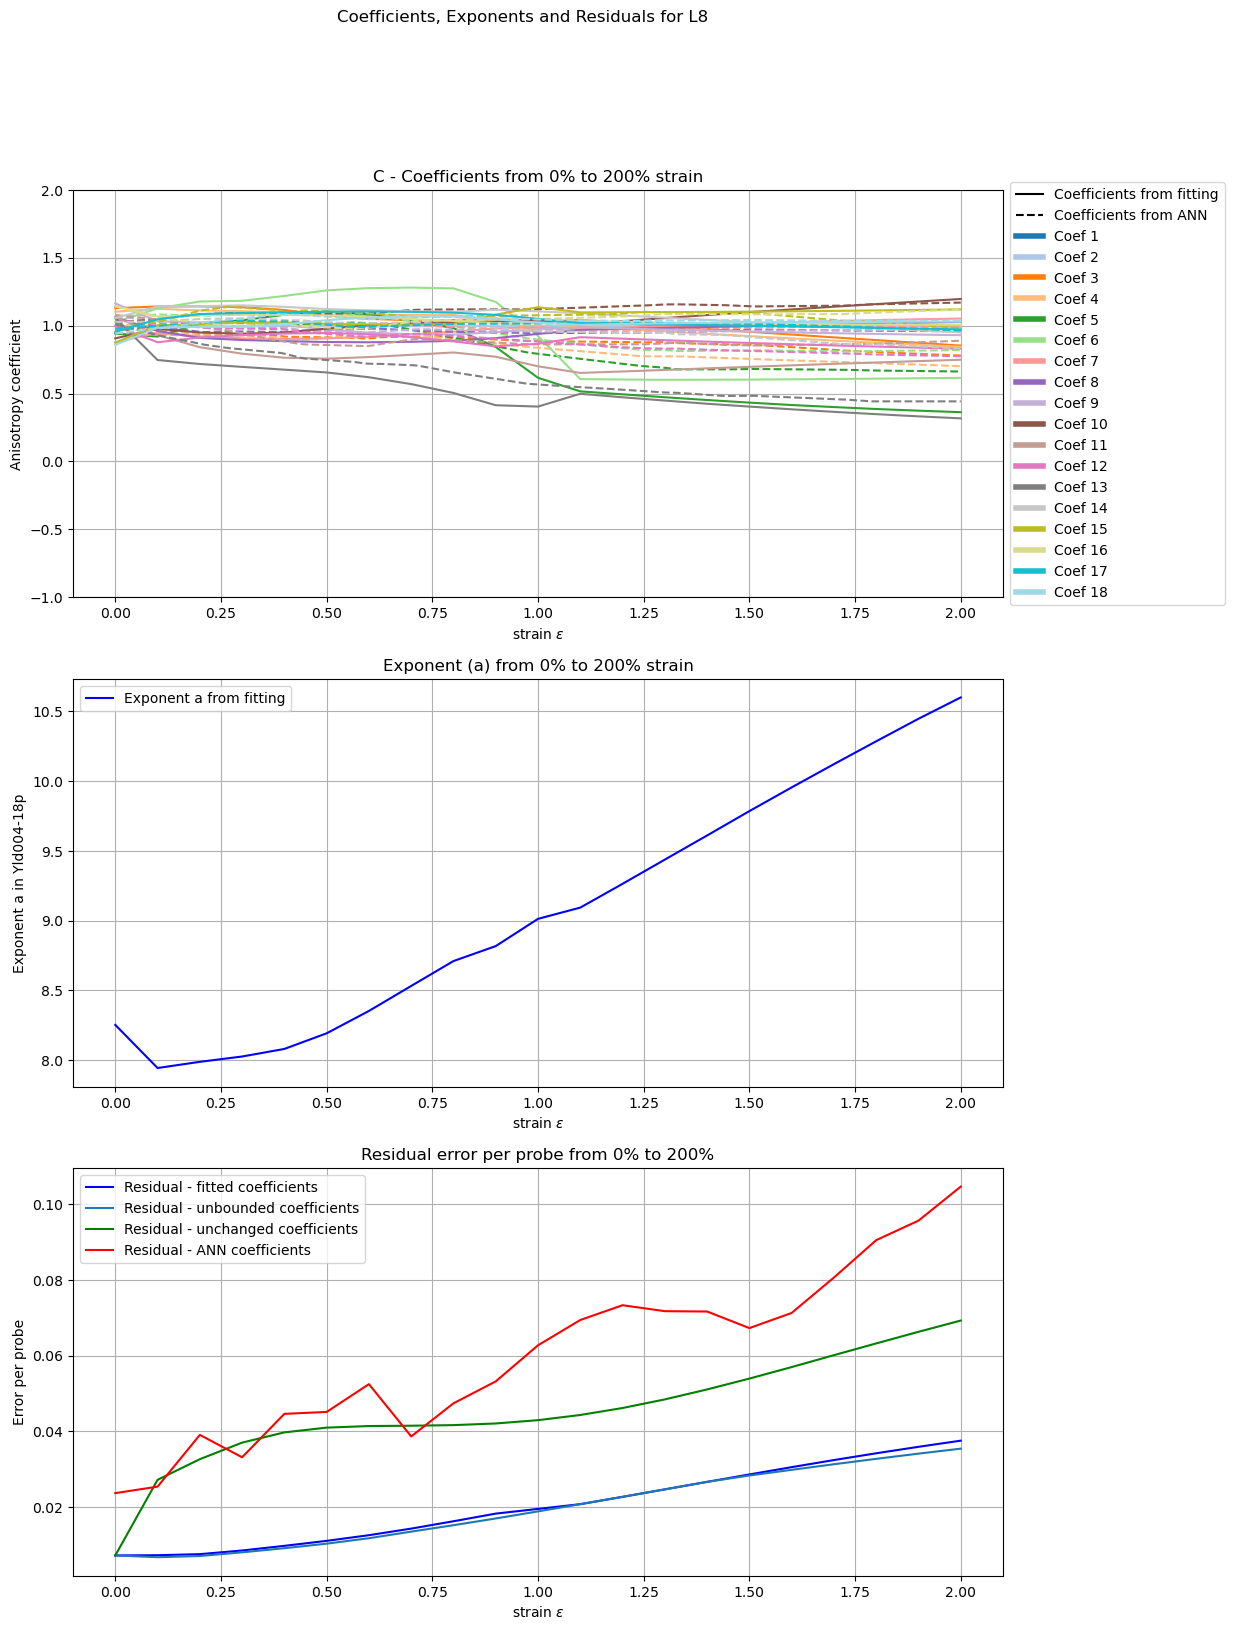

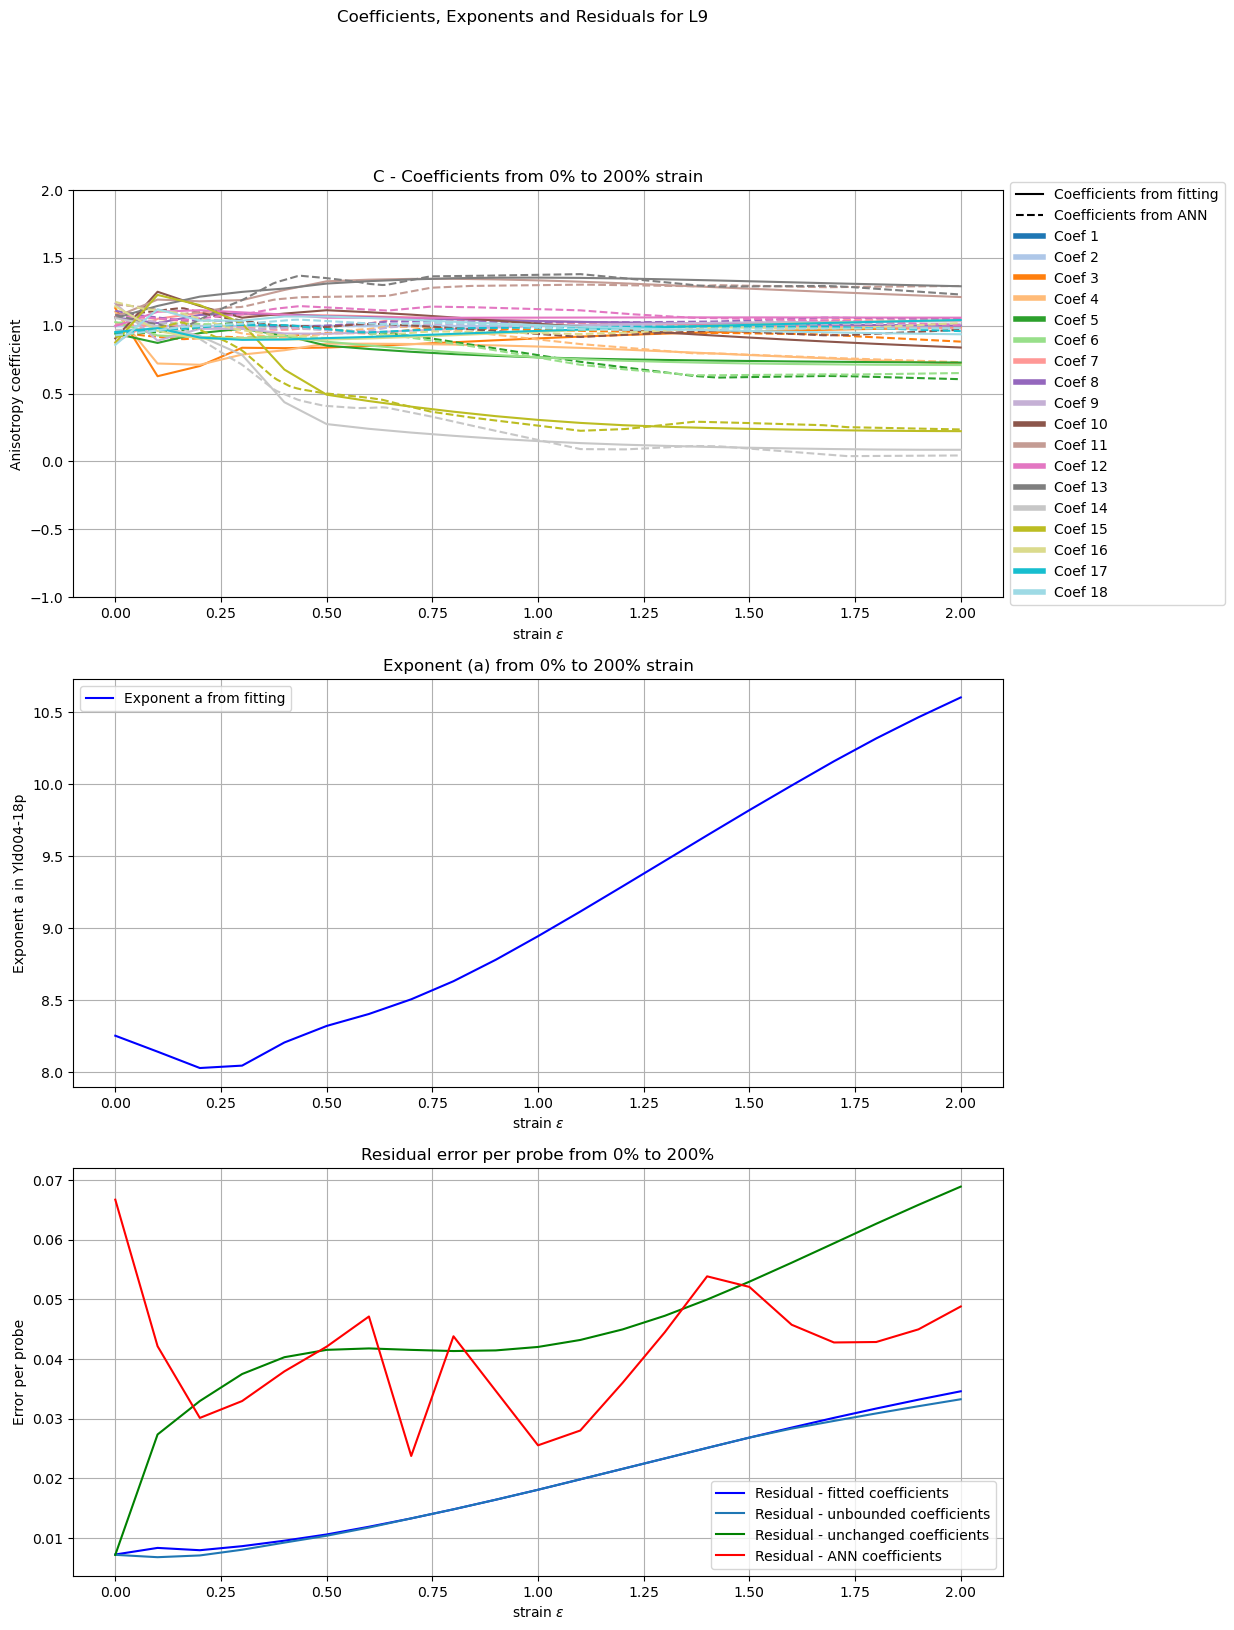

In [55]:
#Plot coefficients, exponents andd residuals for all Ls used during the fitting procedure
strain = np.linspace(0,2, 21,endpoint=True)
strainML =np.linspace(0,2,210,endpoint=True)
fig_axes = [plt.subplots(3,1,figsize=(12,18)) for L in range(len(sorted_files))]
figures = [fig_axes[i][0] for i in range(len(fig_axes))]
axes = [fig_axes[i][1] for i in range(len(fig_axes))]
colors = plt.cm.tab20(np.linspace(0, 1, all_coefs.shape[0]))

legend_elements = [
    plt.Line2D([0], [0], color='k', linestyle='-', label=f'Coefficients from fitting'),
    plt.Line2D([0], [0], color='k', linestyle='--', label=f'Coefficients from ANN'),
] 
for i in range(18): 
    legend_elements.append(plt.Line2D([0],[0],color=colors[i],linewidth=4,label=f'Coef {i+1}'))


for i,(fig,ax) in enumerate(zip(figures,axes)):
    ax[1].plot(strain,all_exps[:,i],'b-',label = 'Exponent a from fitting')
    # ax[1].plot(strain,ML_exps[:,i],'b--',label = 'Exponent a from ANN')

    ax[2].plot(strain,np.sqrt(all_res[:,i]/points[:,i]),'b', label = 'Residual - fitted coefficients')
    ax[2].plot(strain,np.sqrt(unbounded_res[:,i]/points[:,i]), label ='Residual - unbounded coefficients')
    ax[2].plot(strain,np.sqrt(unchanged_res[:,i]/points[:,i]),'g-',label ='Residual - unchanged coefficients')
    ax[2].plot(strain,np.sqrt(ML_res[::10,i]/points[:,i]),'r',label ='Residual - ANN coefficients')

    if i == 0:
        ax[2].plot(strain[1:],np.sqrt(manyiter_res/points[1:,i]),label ='Residual - 1000 iterations coefficients')
        pass
    for k in range(all_coefs.shape[0]):
        ax[0].plot(strain, all_coefs[k,:,i],color=colors[k])
        ax[0].plot(strainML, ML_coefs[k,:,i],color=colors[k],ls='--')
        
    for plot in ax: 
        plot.grid()
        plot.legend()
        plot.set_xlabel(r'strain $\varepsilon$')
    
    fig.suptitle(f'Coefficients, Exponents and Residuals for L{i}')
    ax[0].set_ylim(-1,2)
    ax[0].set_ylabel('Anisotropy coefficient')
    ax[1].set_ylabel('Exponent a in Yld004-18p')
    ax[2].set_ylabel('Error per probe')
    #ax[1].set_ylim(7,14)
    #ax[2].set_yscale('log')
    ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5),handles=legend_elements)

    ax[0].set_title('C - Coefficients from 0% to 200% strain')
    ax[1].set_title('Exponent (a) from 0% to 200% strain')
    ax[2].set_title('Residual error per probe from 0% to 200%')
 
# for j, single_ax in enumerate(ax):
#         extent = single_ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#         expanded_extent = extent.expanded(1.2, 1.2)  # Add 20% padding
#         if j == 0:
#             expanded_extent = extent.expanded(1.5,1.2)
#             expanded_extent.x0 += 1  # Extend leftward
#             #expanded_extent.y1 += 0.8
#         fig.savefig(
#             os.path.join(
#                 r'C:\Users\frear\OneDrive - NTNU\HØST 2024\Prosjektoppgave\Plots and Pictures\Full plots\RNN 1',
#                 f'ANN_L{i}_ax{j}.png'
#             ),
#             bbox_inches=expanded_extent,
#             dpi=300
#         )
    #fig.savefig(os.path.join(r'C:\Users\frear\OneDrive - NTNU\HØST 2024\Prosjektoppgave\Plots and Pictures\Full plots\RNN 1', f'ANN L{i}.png'), dpi = 300)
  


plt.show()

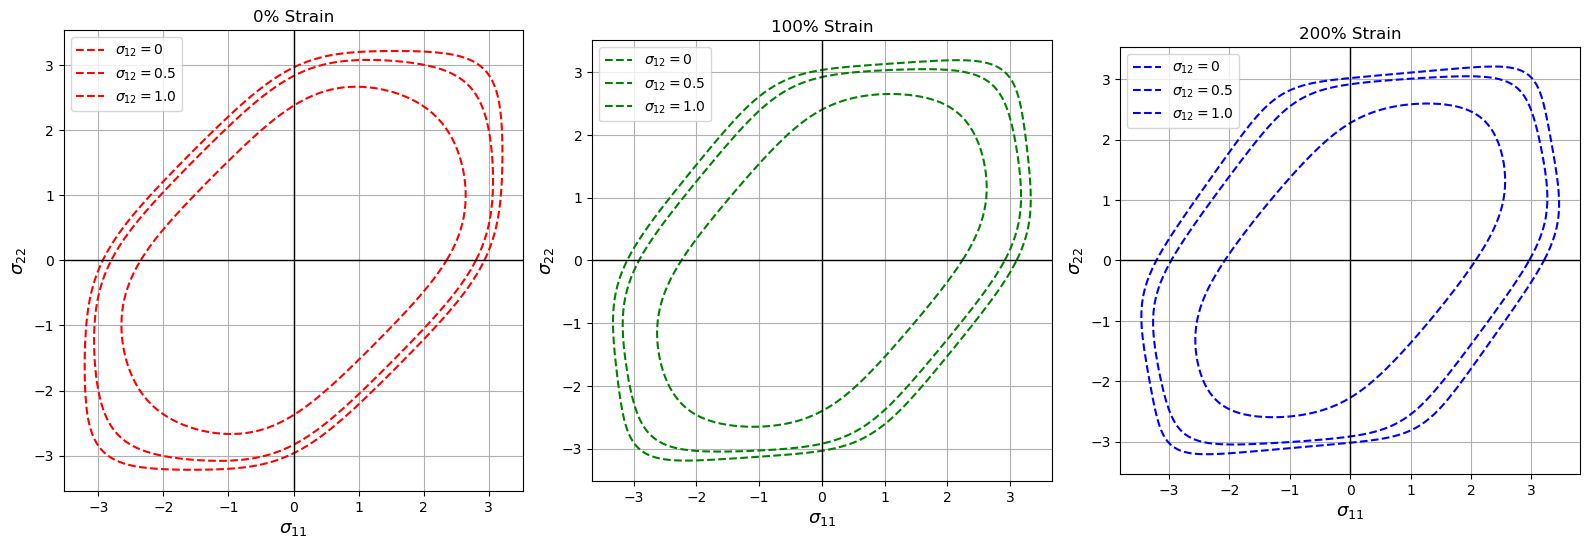

In [ ]:
#Generate stresses from fitted yield function and plot yield curves in chosen stress plane
colors = ['r', 'g', 'b']
dfiles = ['PCYS0.OUT','PCYS09.OUT', 'PCYS19.OUT']
labels = ['2d section', '2d section', '2d section']
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 16), gridspec_kw={'width_ratios': [1, 1,1]})
axs = [ax1,ax2,ax3]
# Plot data on the first axis
coef= all_coefs[:,0,0]
NT = 1
sigY = 3.
case = 'YLD2004_18p'

model = 'YLD2004_18p'
yfun = {'func':model, 
        'coef':coef, 
        'exp':a, 
        'Ntransf':NT,
        'y0':sigY}
plots = [('11','22','12',[0,.5,1.0])]

for i in range(3):
    coef = all_coefs[:,0,0]
    exp = all_exps[0,0]
    yfun['coef'] = coef
    yfun['exp'] = exp
    gs = yf.genStresses(400, yfun, plot_axes=plots[0], save2file=False)

    ax1.plot(gs[0,0,400*i:400*(i+1)], gs[1,1,400*i:400*(i+1)], "--r",label=r'$\sigma_{12} =$' + f'{plots[0][3][i]}')
    ax1.set_title("0% Strain")
    coef= all_coefs[:,10,0]
    exp = all_exps[10,0]
    yfun['coef'] = coef
    yfun['exp'] = exp

    gs = yf.genStresses(400, yfun, plot_axes=plots[0], save2file=False)
    ax2.plot(gs[0,0,400*i:400*(i+1)], gs[1,1,400*i:400*(i+1)], "--g",label=r'$\sigma_{12} =$' + f'{plots[0][3][i]}')
    ax2.set_title("100% Strain")
    coef= all_coefs[:,20,0]
    exp = all_exps[20,0]
    yfun['coef'] = coef
    yfun['exp'] = exp
    gs = yf.genStresses(400, yfun, plot_axes=plots[0], save2file=False)

    ax3.plot(gs[0,0,400*i:400*(i+1)], gs[1,1,400*i:400*(i+1)], "--b",label=r'$\sigma_{12} =$' + f'{plots[0][3][i]}')
    ax3.set_title("200% Strain")

labels = [r"0% strain",r'100% strain', r"200% strain"]
colors = ['r', 'g', 'b']

# for i,file in enumerate(dfiles):
#     s2 = read_2d_PCYS(file)
#     print(s2.shape)
#     sig11 = 1/np.sqrt(6)*(-np.sqrt(3)*s2[:,0]-3*s2[:,1])
#     sig22 = 1/np.sqrt(6)*(np.sqrt(3)*s2[:,0]-3*s2[:,1])
#     if i == 0:
#         ax1.plot(sig11,sig22,'.',color = colors[i],label = labels[i])
#     elif i ==1:
#         ax2.plot(sig11,sig22,'.',color = colors[i],label = labels[i])
#     else:
#         ax3.plot(sig11,sig22,'.',color = colors[i],label = labels[i])

for ax in axs:
    ax.axhline(0, color='black', linewidth=1)  
    ax.axvline(0, color='black', linewidth=1)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.legend()
    ax.set_ylabel(r'$\sigma_{22}$',fontsize=13)
    ax.set_xlabel(r'$\sigma_{11}$',fontsize=13)

plt.tight_layout()
plt.show()

(73, 5)
(73, 5)
(73, 5)


IndexError: list index out of range

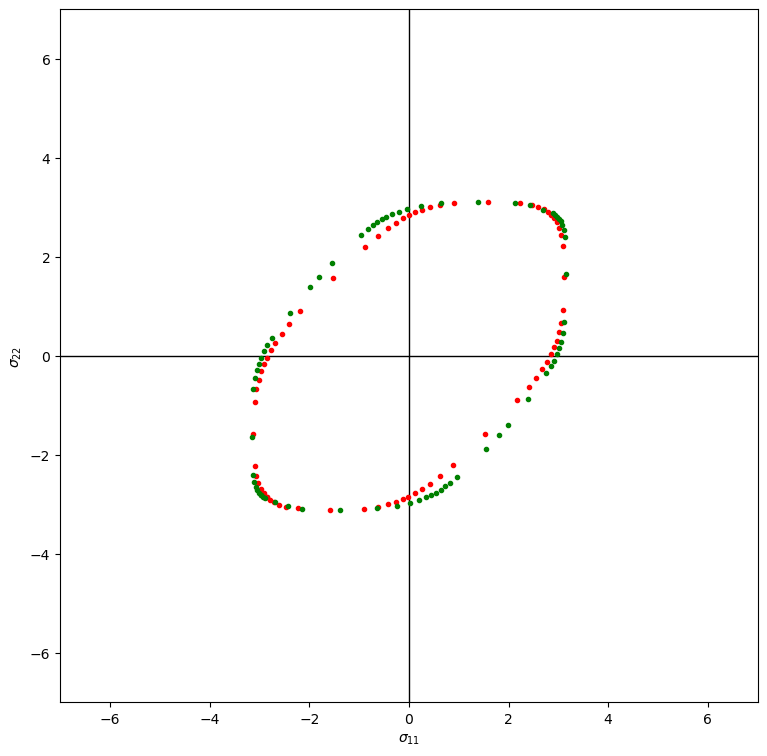

In [31]:
#2d conversions
colors = ['r', 'g', 'b']
dfiles = ['PCYS0.OUT','PCYS09.OUT', 'PCYS19.OUT']


fig, ax =plt.subplots(figsize=(9,9))
ax.set_xlim(-7,7)
ax.set_ylim(-7,7)

ax.axhline(0, color='black', linewidth=1)  
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel(r'$\sigma_{11}$')
ax.set_ylabel(r'$\sigma_{22}$')
labels = [r"10% strain", r"200% strain"]
lines = []
for i,file in enumerate(dfiles):
    s2 = read_2d_PCYS(file)
    print(s2.shape)
    sig11 = 1/np.sqrt(6)*(-np.sqrt(3)*s2[:,0]-3*s2[:,1])
    sig22 = 1/np.sqrt(6)*(np.sqrt(3)*s2[:,0]-3*s2[:,1])
    ax.plot(sig11,sig22,'.',color = colors[i],label = labels[i])
    

for i,(file,ax) in enumerate(zip(dfiles,axs)):
    s2 = read_2d_PCYS(file)
    print(s2.shape)
    sig11 = 1/np.sqrt(6)*(-np.sqrt(3)*s2[:,0]-3*s2[:,1])
    sig22 = 1/np.sqrt(6)*(np.sqrt(3)*s2[:,0]-3*s2[:,1])
    ax.plot(sig11,sig22,'.',color = colors[i],label = labels[i])
    ax.set_ylabel(r'$\sigma_{22}$')
    ax.set_xlabel(r'$\sigma_{11}$')
    ax.legend()
# Adjust layout and display the plot

In [ ]:
coef = np.ones(16)
a = 8.
coefs = np.concatenate((coef,[a]))
lower_bounds = np.concatenate((-np.ones(16),[2]))
upper_bounds = np.concatenate((np.ones(16),[12]))
bounds = (lower_bounds,upper_bounds)
n_dim = 17 # changing 17 parameters

options = {'c1': 0.7,      # Cognitive parameter (influence of personal best)
    'c2': 0.5,      # Social parameter (influence of global best)
    'w': 0.9,       # Inertia parameter (how much particles retain velocity)
    }

optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=n_dim, options=options)
args = {'model': model,
         'NT' : NT,
         'y0': sigY}

def objective_function(params, model, NT, y0):
    costs = []
    for particle in params:
        try:
            cost = yf.get_coefa(particle, model, NT, y0)
            costs.append(cost)
        except ValueError as e:
            print(f"Error with particle {particle}: {e}")
            costs.append(float("inf"))  # Set high cost for problematic particles
    return np.array(costs)

#best_cost, best_params = optimizer.optimize(objective_function, iters=50,**args)


In [ ]:
theta =np.deg2rad(8)
def f(x):
    return x**2 
def fprime(x):
    return 2*x
time = np.arange(0,21,1)
f_eval = np.random.uniform(-1,1,21)

y = np.zeros((21,2))

for i in range(len(time)-1):
    change =  f_eval[i+1] - f_eval[i]
    y[i] = np.array([(np.sin(theta)-change*np.cos(theta))/(-change*np.sin(theta)-np.cos(theta)),(np.sin(theta)+change*np.cos(theta))/(-change*np.sin(theta)+np.cos(theta))])
    y[i] = np.sort(y[i],axis=0)


NT = 1
sigY = 3.
case = 'YLD2004_18p'

def coefficient_calculator_full(full_files,model='YLD2004_18p', mode='get_coefa', minimizer=basinhopping,bounded=True):
    
    coefs = np.ones(16)
    a = 8.

    if mode == 'get_coefa':
        coefs = np.concatenate((coefs,[a]))
        bounds = [tuple(x) for x in len(coefs)*[[None,None]]]
        bounds[-1]= (2,50)
    else:
        bounds = [tuple(x) for x in len(coefs)*[[None,None]]]
        bounds.append((2,50))
    
    all_coefs = np.zeros((18,21,10))
    all_exps = np.zeros((21,10))
    all_res = np.zeros((21,10))

    theta = np.deg2rad(7.5)
    
    bounds = tuple(bounds)

    for L,files in enumerate(full_files):
        #reset bounds for the next Velocity gradient file
        lower_bounds = []
        upper_bounds = []
        tracked_coef = []

        bounds = [tuple(x) for x in len(coefs)*[[None,None]]]
        bounds[-1]= (2,50)

        for i, file in enumerate(files):
            load_stresses(file)
            
            yfun = {'func':model, 
                    'coef':coefs,
                    'info':model, 
                    'exp':a, 
                    'Ntransf':NT,
                    'y0':sigY}
            
            if mode =='get_coefa':
                if minimizer =='minimize':
                    sol = minimize(yf.get_coefa, x0=coefs, args=(model, NT, sigY), method='slsqp', constraints=(),bounds=bounds, jac=None, tol=10**-10, callback=None, options={'maxiter': 10000, 'disp': True}) 
                else:
                    sol = basinhopping(yf.get_coefa, x0=coefs, niter=50, T=1, stepsize=0.5, minimizer_kwargs={'method':'slsqp','args':(model, NT, sigY),'bounds':bounds,'tol':10**-10}, take_step=None, accept_test=None, callback=None, interval=50, disp=True, niter_success=None, seed=None)
                

                yfun['coef'] = np.append([1,1],sol.x[:-1])
                yfun['exp'] = sol.x[-1]
                
                
            if mode =='get_coef':
                #get coef
                if minimizer == 'minimize':
                    sol = minimize(yf.get_coef, x0=coefs, args=(model,a, NT, sigY), method='slsqp', constraints=(),bounds=bounds, jac=None, tol=10**-10, callback=None, options={'maxiter': 10000, 'disp': True}) 
                else:
                    sol = basinhopping(yf.get_coef, x0=coefs, niter=50, T=1, stepsize=0.5, minimizer_kwargs={'method':'slsqp','args':(model,a, NT, sigY),'bounds':bounds,'tol':10**-10}, take_step=None, accept_test=None, callback=None, interval=50, disp=True, niter_success=None, seed=None)

                yfun['exp'] = a
                yfun['coef'] = np.append([1,1],sol.x)
            
            # Loop to update bounds for each coefficient
            tracked_coef.append(sol.x[0])
            if bounded == True:
                bounds = [(None, None)] * len(coefs)
                for j in range(len(coefs)):
                    prev_val = coefs[j]
                    new_val = sol.x[j]
                    change = (new_val - prev_val) + new_val
            
                #  y = np.array([(np.sin(theta)-change**2*np.cos(theta))/(-change*np.sin(theta)-np.cos(theta)),(np.sin(theta)+change*np.cos(theta))/(-change*np.sin(theta)+np.cos(theta))])
                    y = np.array([(np.sin(theta)+change**2*np.sin(theta))/(-change*np.sin(theta)-np.cos(theta)),(np.sin(theta)+change**2*np.sin(theta))/(-change*np.sin(theta)+np.cos(theta))])
            
            
                    lower_bound =  change + np.min(y)
                    upper_bound =  change + np.max(y)
                    # Update bounds for this coefficient
                    bounds[j] = (lower_bound, upper_bound)
                    
                    
                bounds = tuple(bounds)
                lower_bounds.append(bounds[0][0])
                upper_bounds.append(bounds[0][1])
                    
            yfun['residual'] = sol.fun
            if mode == 'get_coefa':
                coefs = np.concatenate((yfun['coef'][2:],[yfun['exp']]))
            else:
                coefs = yfun['coef'][2:]
            
            all_coefs[:,i,L] = yfun['coef']
            all_exps[i,L] = yfun['exp']
            all_res[i,L] = yfun['residual']
        
        plt.figure(figsize=(10, 6))
        plt.plot(range(21),all_exps[:,L],'-r')
        plt.plot(range(21),all_res[:,L],'-b')
        plt.show()
        
        if bounded:
            lower_bounds = [None] + lower_bounds[:-1]
            upper_bounds = [None] + upper_bounds[:-1]

            plt.figure(figsize=(10, 6))
            plt.plot(range(len(files)), lower_bounds, label='Lower Bound', marker='o')
            plt.plot(range(len(files)), upper_bounds, label='Upper Bound', marker='o')
            plt.plot(range(len(files)), tracked_coef, label='coef', marker='x')
            plt.xlabel('Iteration (i)')
            plt.ylabel('Bounds for Coefficient 0')
            plt.title('Bounds Evolution for Coefficient 0')
            plt.legend()
            plt.grid(True)
            plt.show()
    
    return all_coefs, all_exps, all_res


sorted_files = get_sorted_file_lists('FilteredPCYS')
all_coefs , all_exps, all_res = coefficient_calculator_full(sorted_files,minimizer='minimize',bounded = True)       